In [526]:
# Importación de librerías

# Núcleo y utilidades generales
import warnings
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Acceso a datos
from ucimlrepo import fetch_ucirepo

# Estadística
from scipy.stats import (
    normaltest, levene, pointbiserialr,
    spearmanr, chi2_contingency,
    ttest_ind, mannwhitneyu,
    uniform, randint
)

# Scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    make_scorer
)
from sklearn.calibration import CalibratedClassifierCV
from joblib import Memory
import torch
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV

# Modelado y desbalance
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

# Modelos de clasificación
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from pytorch_tabnet.tab_model import TabNetClassifier



### Resumen del caso de estudio

El conjunto “Default of Credit Card Clients” agrupa 30 000 registros de clientes de tarjetas en Taiwán, con variables demográficas (sexo, educación, estado civil, edad), límite de crédito, seis meses de historial de pagos y montos facturados/pagados. Este dataset proviene del UCI Machine Learning Repository (ID 350). La proporción de clases es aproximadamente 22 % de incumplimiento y 78 % de pago. Su propósito es analizar patrones que anticipen quién dejará de pagar al mes siguiente.

### Objetivo del modelo
Formular un clasificador binario que prediga la variable Y (“default next month”: 1 = incumplimiento, 0 = pago), de modo que la entidad financiera pueda ajustar políticas de crédito, provisiones y cobros de forma proactiva.

### Métrica objetivo: Recall de “incumplimiento de pago”

Maximizar el recall (TP / [TP + FN]) asegura detectar la mayor proporción posible de impagos reales. Dado que pasar por alto un incumplimiento genera pérdidas financieras directas muy superiores al coste de falsear un buen cliente, priorizar la sensibilidad es la estrategia más alineada con la gestión de riesgo crediticio.

In [483]:
# Descargando de manera segura del dataset “Default of Credit Card Clients”
#    UCI ML Repository – ID 350

from ucimlrepo import fetch_ucirepo

try:
    dccc = fetch_ucirepo(id=350)          # objeto Dataset (dataclass)
except Exception as err:
    raise RuntimeError(
        "No se pudo descargar el dataset desde UCI ML Repository. "
        "Verifica tu conexión o la disponibilidad del servidor."
    ) from err


# Obtención del DataFrame ORIGINAL

df_dccc: pd.DataFrame = dccc.data.original.copy()
assert df_dccc.shape == (30000, 25), \
    f"Estructura inesperada del dataset: {df_dccc.shape}"


# Vista rápida

display(df_dccc.head(15))

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,0,-1,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,-1,-1,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0


In [484]:
#  Renombrando las columnas X1‑X23 + Y a nombres legibles

renombrar = {
    'ID':  'cliente_id',
    # Datos demográficos y de crédito
    'X1':  'monto_credito',
    'X2':  'genero',
    'X3':  'nivel_educacion',
    'X4':  'estado_civil',
    'X5':  'edad',
    # Historial de pagos (X6=sep‑2005 … X11=abr‑2005)
    'X6':  'pago_sep2005',
    'X7':  'pago_ago2005',
    'X8':  'pago_jul2005',
    'X9':  'pago_jun2005',
    'X10': 'pago_may2005',
    'X11': 'pago_abr2005',
    # Montos facturados
    'X12': 'factura_sep2005',
    'X13': 'factura_ago2005',
    'X14': 'factura_jul2005',
    'X15': 'factura_jun2005',
    'X16': 'factura_may2005',
    'X17': 'factura_abr2005',
    # Montos pagados
    'X18': 'pagado_sep2005',
    'X19': 'pagado_ago2005',
    'X20': 'pagado_jul2005',
    'X21': 'pagado_jun2005',
    'X22': 'pagado_may2005',
    'X23': 'pagado_abr2005',
    # Variable objetivo
    'Y':   'incumplimiento'
}

# Verificación previa: ¿faltan o sobran columnas?
faltantes = set(renombrar) - set(df_dccc.columns)
sobrantes = set(df_dccc.columns) - set(renombrar)
assert not faltantes, f"Faltan columnas esperadas: {faltantes}"
if sobrantes - {'ID'}:
    print("Aviso: columnas no incluidas en el mapeo:", sobrantes - {'ID'})

# Renombrar in‑place
df_dccc.rename(columns=renombrar, inplace=True)

# Vista rápida
display(df_dccc.head())


,cliente_id,monto_credito,genero,nivel_educacion,estado_civil,edad,pago_sep2005,pago_ago2005,pago_jul2005,pago_jun2005,pago_may2005,pago_abr2005,factura_sep2005,factura_ago2005,factura_jul2005,factura_jun2005,factura_may2005,factura_abr2005,pagado_sep2005,pagado_ago2005,pagado_jul2005,pagado_jun2005,pagado_may2005,pagado_abr2005,incumplimiento
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [485]:
# Inspeccionando dimensiones del DataFrame

filas, columnas = df_dccc.shape
print(f"Tamaño del DataFrame: {filas} filas × {columnas} columnas")


Tamaño del DataFrame: 30000 filas × 25 columnas


In [486]:
# Validando el tipo de datos de cada columna

# Tipos de datos
print("\nTipos de datos por columna:")
print(df_dccc.dtypes)



Tipos de datos por columna:
cliente_id         int64
monto_credito      int64
genero             int64
nivel_educacion    int64
estado_civil       int64
edad               int64
pago_sep2005       int64
pago_ago2005       int64
pago_jul2005       int64
pago_jun2005       int64
pago_may2005       int64
pago_abr2005       int64
factura_sep2005    int64
factura_ago2005    int64
factura_jul2005    int64
factura_jun2005    int64
factura_may2005    int64
factura_abr2005    int64
pagado_sep2005     int64
pagado_ago2005     int64
pagado_jul2005     int64
pagado_jun2005     int64
pagado_may2005     int64
pagado_abr2005     int64
incumplimiento     int64
dtype: object


In [487]:
# Identificando valores nulos en el DataFrame

# Valores nulos

nulos_abs = df_dccc.isnull().sum()
nulos_pct = (nulos_abs / len(df_dccc) * 100).round(2)

resumen_nulos = pd.DataFrame({
    "nulos": nulos_abs,
    "%":     nulos_pct
})

print(resumen_nulos)


                 nulos    %
cliente_id           0  0.0
monto_credito        0  0.0
genero               0  0.0
nivel_educacion      0  0.0
estado_civil         0  0.0
edad                 0  0.0
pago_sep2005         0  0.0
pago_ago2005         0  0.0
pago_jul2005         0  0.0
pago_jun2005         0  0.0
pago_may2005         0  0.0
pago_abr2005         0  0.0
factura_sep2005      0  0.0
factura_ago2005      0  0.0
factura_jul2005      0  0.0
factura_jun2005      0  0.0
factura_may2005      0  0.0
factura_abr2005      0  0.0
pagado_sep2005       0  0.0
pagado_ago2005       0  0.0
pagado_jul2005       0  0.0
pagado_jun2005       0  0.0
pagado_may2005       0  0.0
pagado_abr2005       0  0.0
incumplimiento       0  0.0


In [488]:
# Identificando posibles valores duplicados en el DataFrame

# Duplicados

dup_filas = df_dccc.duplicated().sum()
dup_id    = df_dccc['cliente_id'].duplicated().sum()

print(f"Filas duplicadas completas: {dup_filas}")
print(f"IDs de cliente duplicados:  {dup_id}")


Filas duplicadas completas: 0
IDs de cliente duplicados:  0


In [489]:
# Asignando nombres a las variables categóricas

# Copia de trabajo
df_limpio = df_dccc.copy()

# Diccionarios de mapeo
map_genero       = {1: 'hombre', 2: 'mujer'}
map_educacion    = {1: 'posgrado', 2: 'universidad', 3: 'secundaria', 4: 'otros'}
map_estado_civil = {1: 'casado', 2: 'soltero', 3: 'otros'}
map_incumpl      = {0: 'no incumple', 1: 'incumple'}

# Conversión simple
df_limpio['genero']           = df_limpio['genero'].map(map_genero).fillna('desconocido').astype('category')
df_limpio['nivel_educacion']  = df_limpio['nivel_educacion'].map(map_educacion).fillna('desconocido').astype('category')
df_limpio['estado_civil']     = df_limpio['estado_civil'].map(map_estado_civil).fillna('desconocido').astype('category')
df_limpio['incumplimiento_txt'] = df_limpio['incumplimiento'].map(map_incumpl).astype('category')

# Historial de pagos (‑2 a 9)
map_historial_pago = {-2: 'pago adelantado', -1: 'pago puntual', 0: 'pago pendiente',
                      **{i: f'retraso {i} meses' for i in range(1, 10)}}

cols_hist = ['pago_sep2005','pago_ago2005','pago_jul2005',
             'pago_jun2005','pago_may2005','pago_abr2005']

for col in cols_hist:
    df_limpio[f'{col}_txt'] = (
        df_limpio[col]
          .map(map_historial_pago)
          .fillna('desconocido')
          .astype('category')
    )

# Vista rápida
display(df_limpio.head())

,cliente_id,monto_credito,genero,nivel_educacion,estado_civil,edad,pago_sep2005,pago_ago2005,pago_jul2005,pago_jun2005,pago_may2005,pago_abr2005,factura_sep2005,factura_ago2005,factura_jul2005,factura_jun2005,factura_may2005,factura_abr2005,pagado_sep2005,pagado_ago2005,pagado_jul2005,pagado_jun2005,pagado_may2005,pagado_abr2005,incumplimiento,incumplimiento_txt,pago_sep2005_txt,pago_ago2005_txt,pago_jul2005_txt,pago_jun2005_txt,pago_may2005_txt,pago_abr2005_txt
0,1,20000,mujer,universidad,casado,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,incumple,retraso 2 meses,retraso 2 meses,pago puntual,pago puntual,pago adelantado,pago adelantado
1,2,120000,mujer,universidad,soltero,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,incumple,pago puntual,retraso 2 meses,pago pendiente,pago pendiente,pago pendiente,retraso 2 meses
2,3,90000,mujer,universidad,soltero,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,no incumple,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente
3,4,50000,mujer,universidad,casado,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,no incumple,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente
4,5,50000,hombre,universidad,casado,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,no incumple,pago puntual,pago pendiente,pago puntual,pago pendiente,pago pendiente,pago pendiente


In [490]:
# Tipos de datos de cada columna

# Tipos de datos
print("Tipos de datos por columna:\n")
print(df_limpio.dtypes)

# Resumen rápido
num_cols = df_limpio.select_dtypes(include='number').columns
cat_cols = df_limpio.select_dtypes(exclude='number').columns

print(f"\nTotal columnas:        {df_limpio.shape[1]}")
print(f"  Numéricas:           {len(num_cols)}")
print(f"  Categóricas/otras:   {len(cat_cols)}")



Tipos de datos por columna:

cliente_id               int64
monto_credito            int64
genero                category
nivel_educacion       category
estado_civil          category
edad                     int64
pago_sep2005             int64
pago_ago2005             int64
pago_jul2005             int64
pago_jun2005             int64
pago_may2005             int64
pago_abr2005             int64
factura_sep2005          int64
factura_ago2005          int64
factura_jul2005          int64
factura_jun2005          int64
factura_may2005          int64
factura_abr2005          int64
pagado_sep2005           int64
pagado_ago2005           int64
pagado_jul2005           int64
pagado_jun2005           int64
pagado_may2005           int64
pagado_abr2005           int64
incumplimiento           int64
incumplimiento_txt    category
pago_sep2005_txt      category
pago_ago2005_txt      category
pago_jul2005_txt      category
pago_jun2005_txt      category
pago_may2005_txt      category
pago_abr20

In [491]:
# Estadísticas descriptivas de variables numéricas

# Estadísticas descriptivas
num_cols = (
    df_limpio.select_dtypes(include='number')
             .columns.difference(['cliente_id', 'incumplimiento'])
)

stats = df_limpio[num_cols].describe(
            percentiles=[.01, .25, .5, .75, .99]
        )

# Añadimos sesgo y curtosis como nuevas filas
stats.loc['sesgo']    = df_limpio[num_cols].skew()
stats.loc['curtosis'] = df_limpio[num_cols].kurt()

# Redondeo opcional para legibilidad
stats = stats.round(2)

print("Resumen estadístico:")
display(stats)


Resumen estadístico:


,edad,factura_abr2005,factura_ago2005,factura_jul2005,factura_jun2005,factura_may2005,factura_sep2005,monto_credito,pagado_abr2005,pagado_ago2005,pagado_jul2005,pagado_jun2005,pagado_may2005,pagado_sep2005,pago_abr2005,pago_ago2005,pago_jul2005,pago_jun2005,pago_may2005,pago_sep2005
count,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00
mean,35.49,38871.76,49179.08,47013.15,43262.95,40311.40,51223.33,167484.32,5215.50,5921.16,5225.68,4826.08,4799.39,5663.58,-0.29,-0.13,-0.17,-0.22,-0.27,-0.02
std,9.22,59554.11,71173.77,69349.39,64332.86,60797.16,73635.86,129747.66,17777.47,23040.87,17606.96,15666.16,15278.31,16563.28,1.15,1.20,1.20,1.17,1.13,1.12
min,21.00,-339603.00,-69777.00,-157264.00,-170000.00,-81334.00,-165580.00,10000.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00
1%,22.00,-331.03,-200.00,-200.00,-212.02,-232.01,-81.00,10000.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00
25%,28.00,1256.00,2984.75,2666.25,2326.75,1763.00,3558.75,50000.00,117.75,833.00,390.00,296.00,252.50,1000.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
50%,34.00,17071.00,21200.00,20088.50,19052.00,18104.50,22381.50,140000.00,1500.00,2009.00,1800.00,1500.00,1500.00,2100.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,41.00,49198.25,64006.25,60164.75,54506.00,50190.50,67091.00,240000.00,4000.00,5000.00,4505.00,4013.25,4031.50,5006.00,0.00,0.00,0.00,0.00,0.00,0.00
99%,60.00,279505.06,337495.28,325030.39,304997.27,285868.33,350110.68,500000.00,82619.05,76651.02,70000.00,67054.44,65607.56,66522.18,3.00,3.00,3.00,3.00,3.00,3.00
max,79.00,961664.00,983931.00,1664089.00,891586.00,927171.00,964511.00,1000000.00,528666.00,1684259.00,896040.00,621000.00,426529.00,873552.00,8.00,8.00,8.00,8.00,8.00,8.00


In [492]:
# Estadísticas descriptivas de variables categóricas

# Estadísticas descriptivas de variables categóricas
cat_cols = [
    'genero','nivel_educacion','estado_civil','incumplimiento_txt',
    'pago_sep2005_txt','pago_ago2005_txt','pago_jul2005_txt',
    'pago_jun2005_txt','pago_may2005_txt','pago_abr2005_txt'
]

df_cat = df_limpio[cat_cols]


desc_cat = df_cat.describe().T

# % nulos
nulos_abs = df_cat.isnull().sum()
desc_cat['nulos'] = nulos_abs
desc_cat['% nulos'] = (nulos_abs / len(df_cat) * 100).round(2)

# % de la categoría dominante (top)
desc_cat['% top'] = (desc_cat['freq'] / len(df_cat) * 100).round(1)

print("\nResumen categóricas (nulos y % categoría dominante):")
display(desc_cat[['count','unique','top','freq','% top','nulos','% nulos']])





Resumen categóricas (nulos y % categoría dominante):


,count,unique,top,freq,% top,nulos,% nulos
genero,30000,2,mujer,18112,60.373333,0,0.0
nivel_educacion,30000,5,universidad,14030,46.766667,0,0.0
estado_civil,30000,4,soltero,15964,53.213333,0,0.0
incumplimiento_txt,30000,2,no incumple,23364,77.88,0,0.0
pago_sep2005_txt,30000,11,pago pendiente,14737,49.123333,0,0.0
pago_ago2005_txt,30000,11,pago pendiente,15730,52.433333,0,0.0
pago_jul2005_txt,30000,11,pago pendiente,15764,52.546667,0,0.0
pago_jun2005_txt,30000,11,pago pendiente,16455,54.85,0,0.0
pago_may2005_txt,30000,10,pago pendiente,16947,56.49,0,0.0
pago_abr2005_txt,30000,10,pago pendiente,16286,54.286667,0,0.0


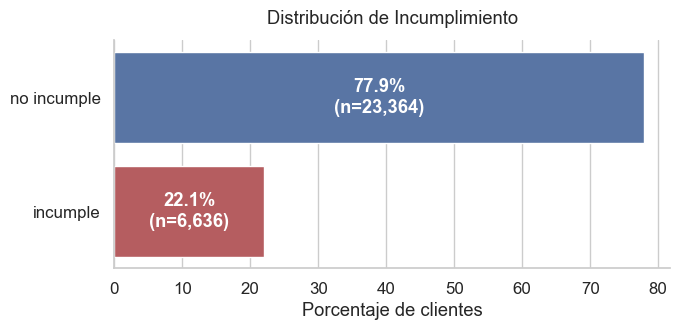

In [493]:
# Distribución de la variable objetivo con porcentajes

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top']   = False

orden = ['no incumple', 'incumple']
counts = (df_limpio['incumplimiento_txt']
          .value_counts()
          .reindex(orden, fill_value=0))
perc = (counts / counts.sum() * 100).round(1)

df_plot = pd.DataFrame({
    'estado':     orden,
    'percentage': perc.values,
    'n':          counts.values
})

fig, ax = plt.subplots(figsize=(7, 3.5))
sns.barplot(
    data=df_plot,
    x='percentage',
    y='estado',
    hue='estado',
    palette=['#4C72B0', '#C44E52'],
    dodge=False,
    legend=False,
    ax=ax
)

# Texto centrado
for i, row in df_plot.iterrows():
    ax.text(row.percentage / 2, i,
            f"{row.percentage:.1f}%\n(n={row.n:,})",
            ha='center', va='center',
            color='white', fontweight='bold')

ax.set_title("Distribución de Incumplimiento", pad=12)
ax.set_xlabel("Porcentaje de clientes")
ax.set_ylabel("")

plt.tight_layout()
plt.show()


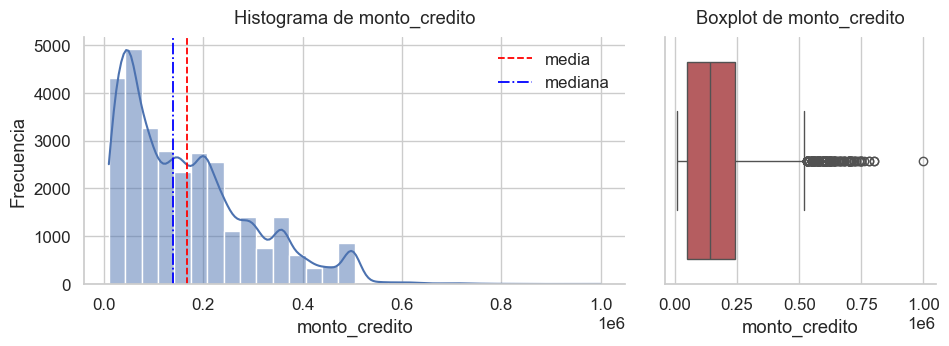

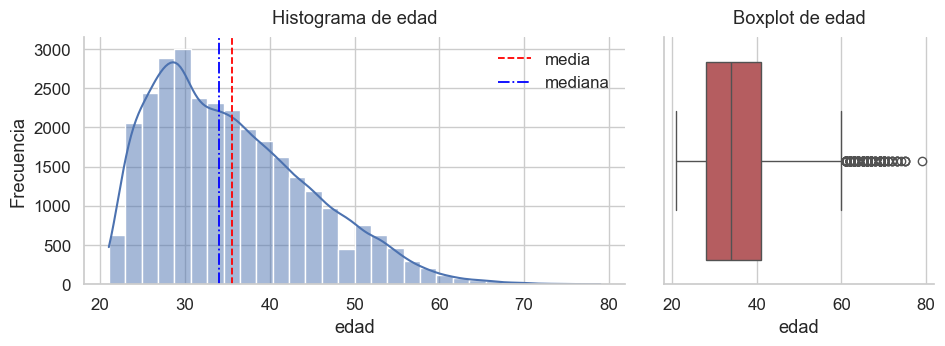

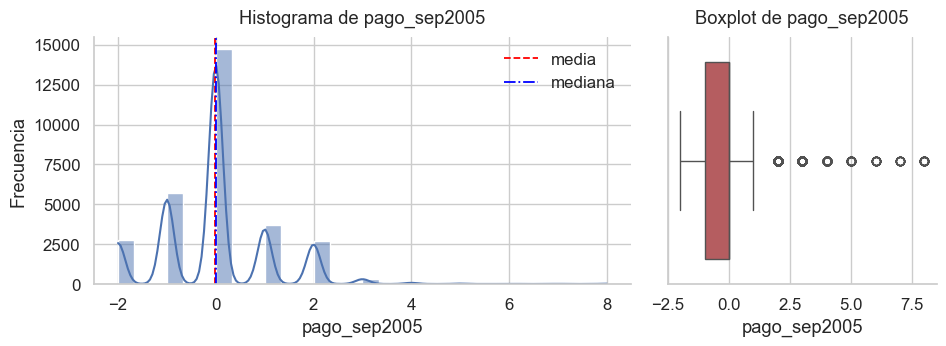

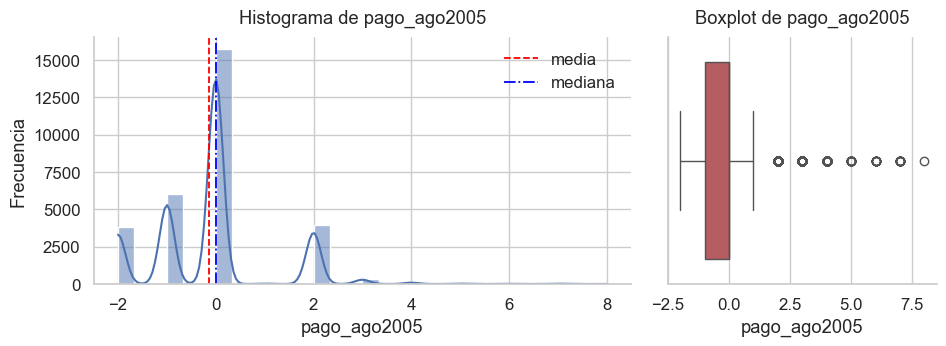

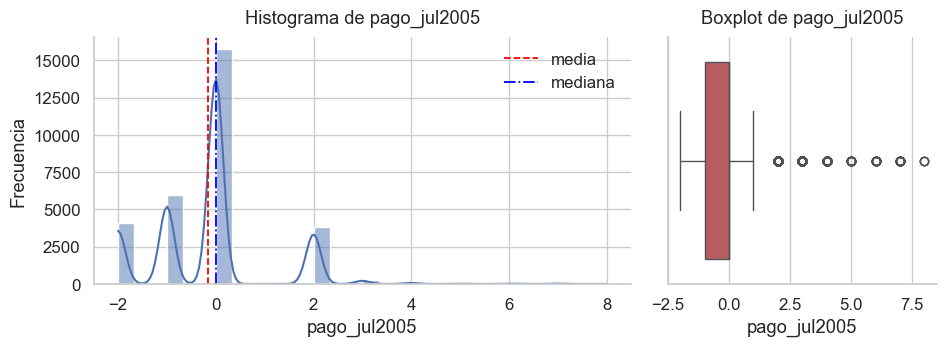

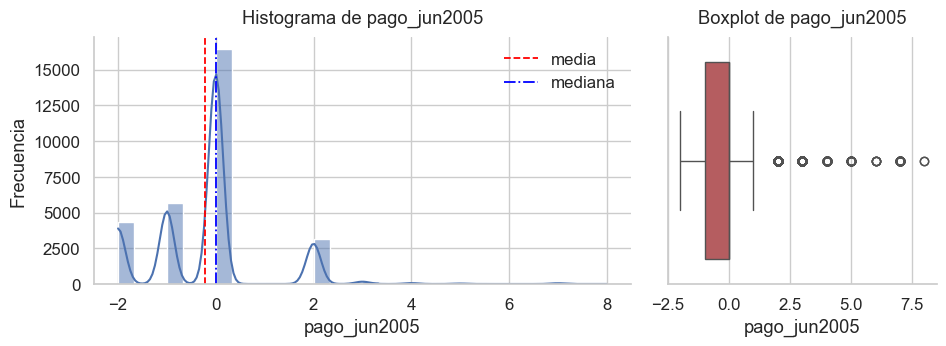

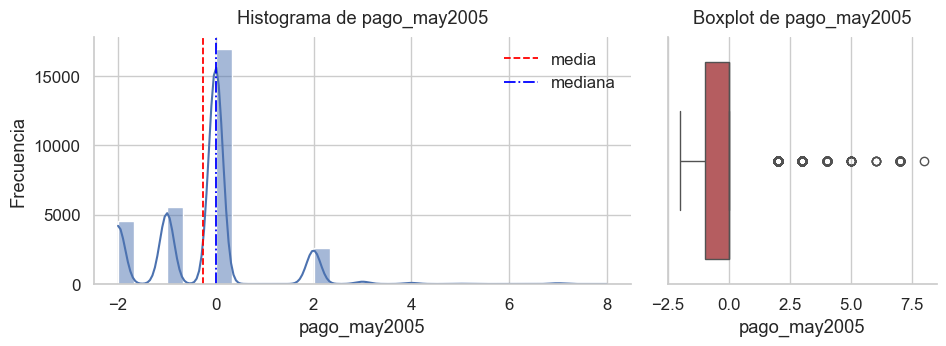

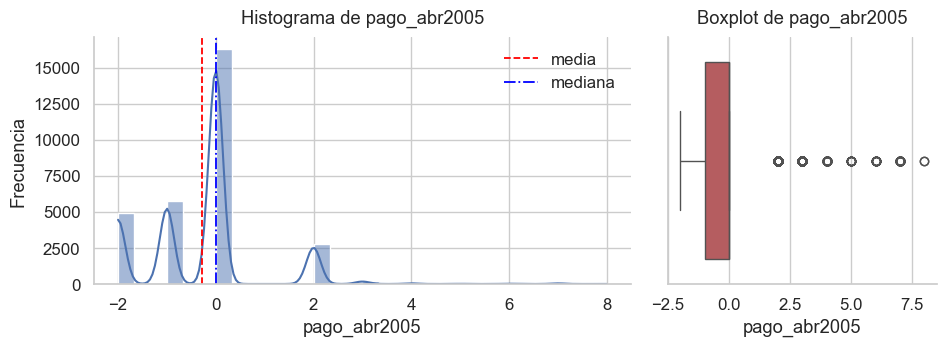

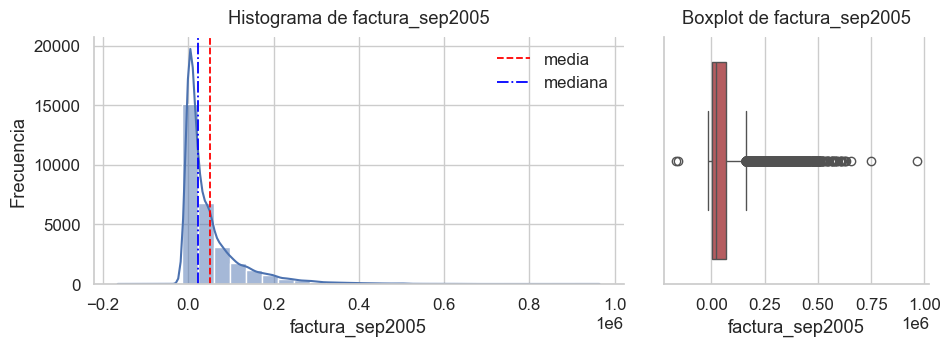

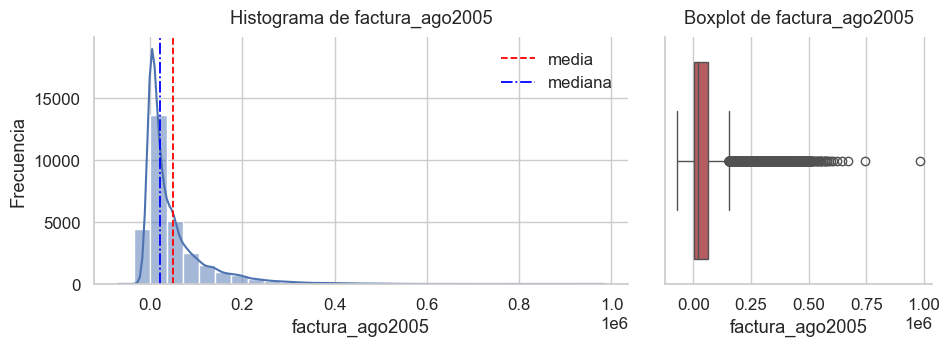

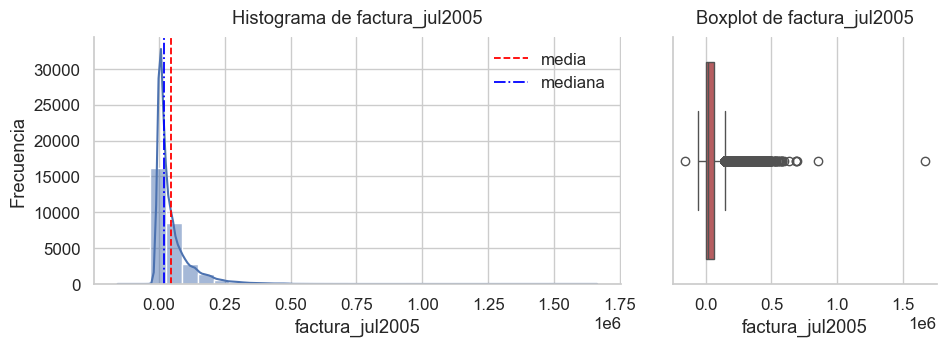

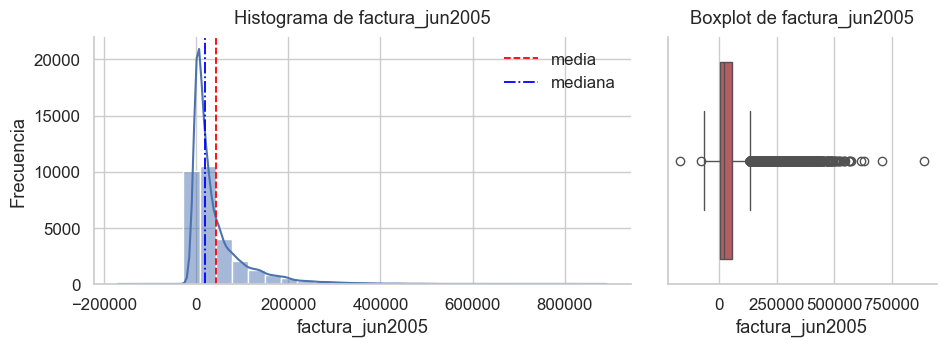

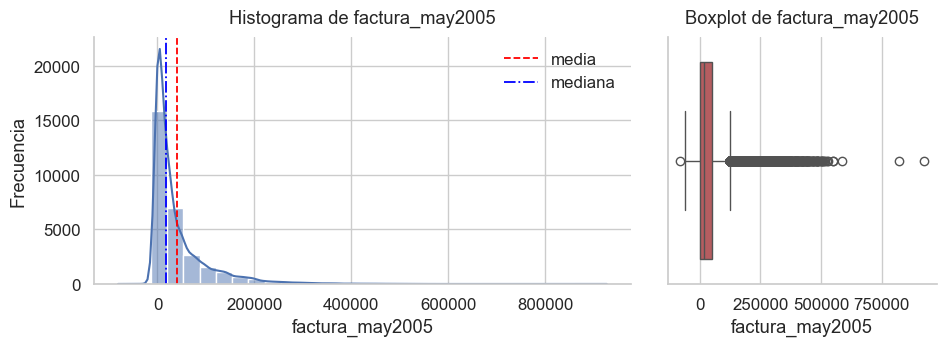

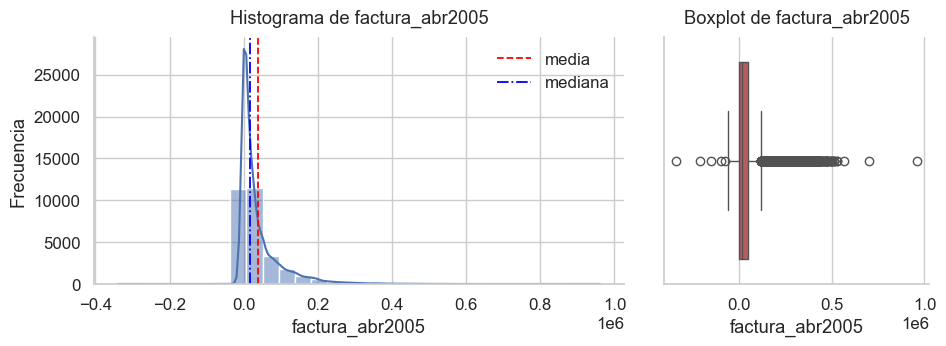

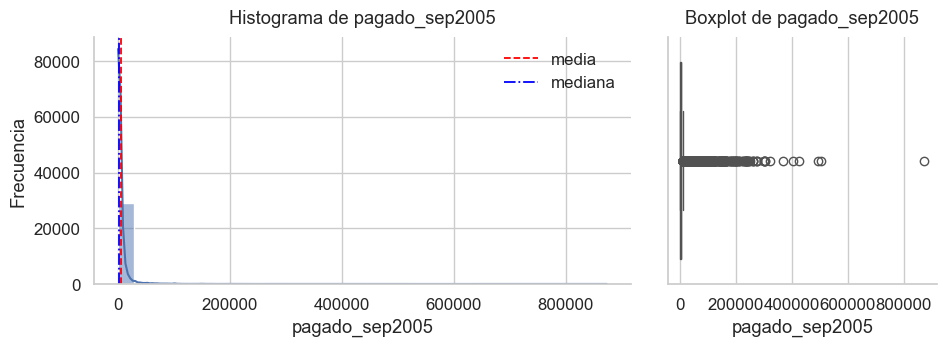

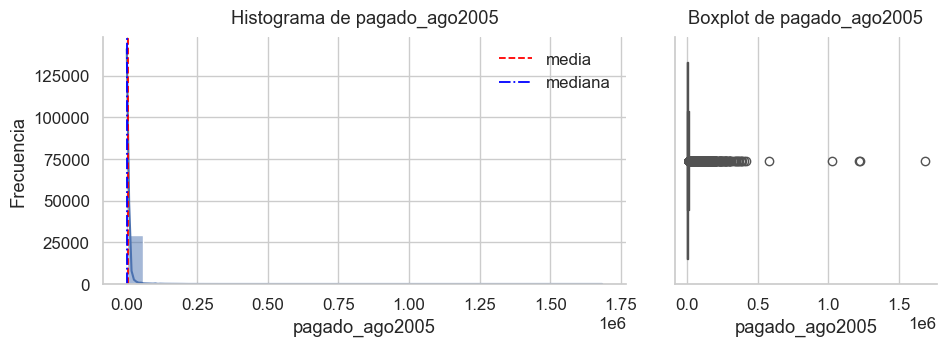

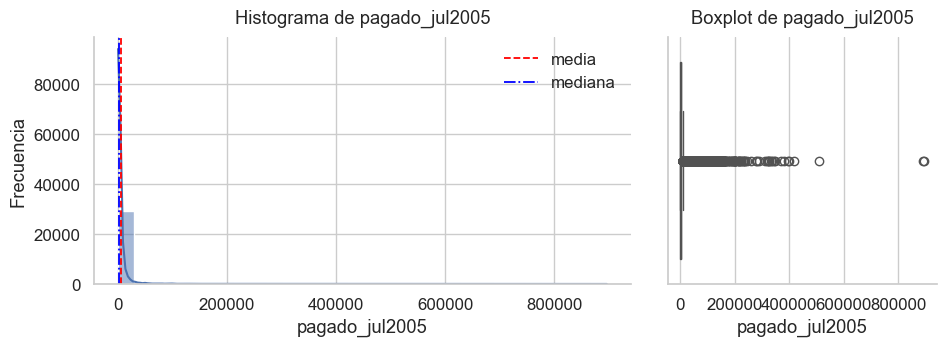

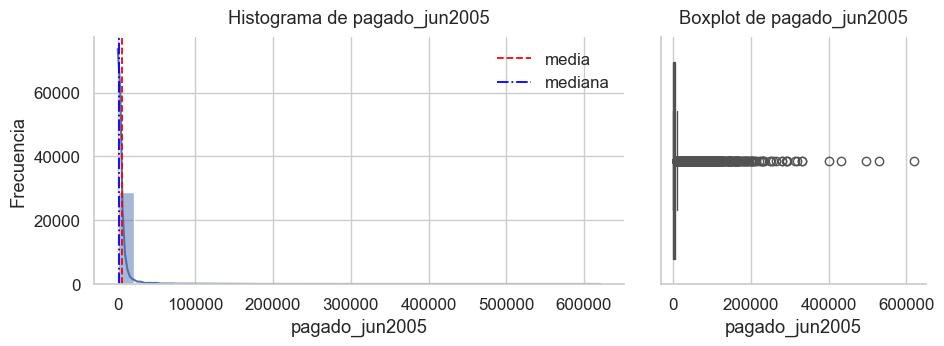

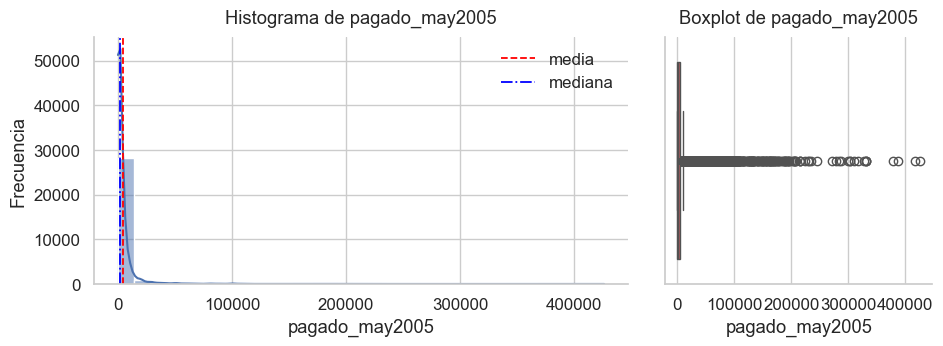

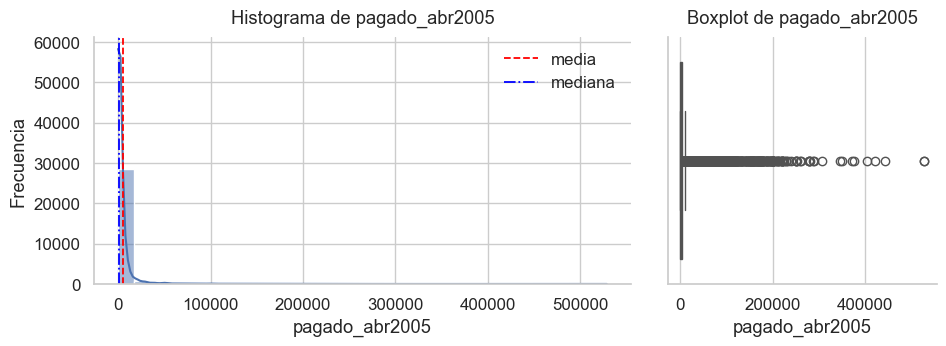

In [494]:
# Análisis univariado de variables numéricas

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

y = df_limpio['incumplimiento']
X = df_limpio.drop(columns=['incumplimiento', 'cliente_id'])

num_vars = X.select_dtypes(include='number').columns

for col in num_vars:
    serie = X[col].dropna()
    skew  = serie.skew()
    use_log = (abs(skew) > 1) and (serie.min() > 0)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4),
                             gridspec_kw={'width_ratios':[2,1]})

    # Histograma + KDE
    ax0 = axes[0]
    sns.histplot(serie, bins=30, kde=True,
                 ax=ax0, color='#4C72B0', edgecolor='white')
    ax0.set_xlabel(col); ax0.set_ylabel('Frecuencia')
    ax0.axvline(serie.mean(),   color='red',  ls='--', lw=1.3, label='media')
    ax0.axvline(serie.median(), color='blue', ls='-.', lw=1.3, label='mediana')
    ax0.legend(frameon=False, loc='upper right')

    # Boxplot
    ax1 = axes[1]
    sns.boxplot(x=serie, ax=ax1, color='#C44E52')
    ax1.set_xlabel(col)

    # Escala log si procede
    if use_log:
        for ax in axes:
            ax.set_xscale('log')
        ax0.set_title(f'{col} (histograma log)', pad=10)
        ax1.set_title(f'{col} (boxplot log)',   pad=10)
    else:
        ax0.set_title(f'Histograma de {col}', pad=10)
        ax1.set_title(f'Boxplot de {col}',     pad=10)

    plt.tight_layout(pad=2)
    plt.show()



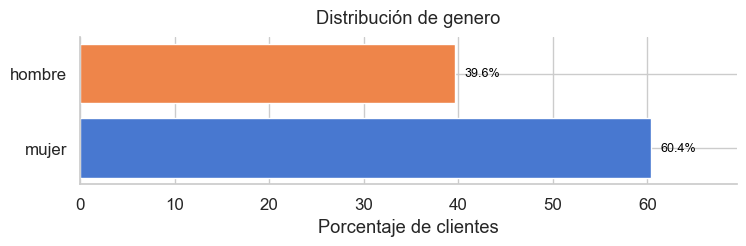

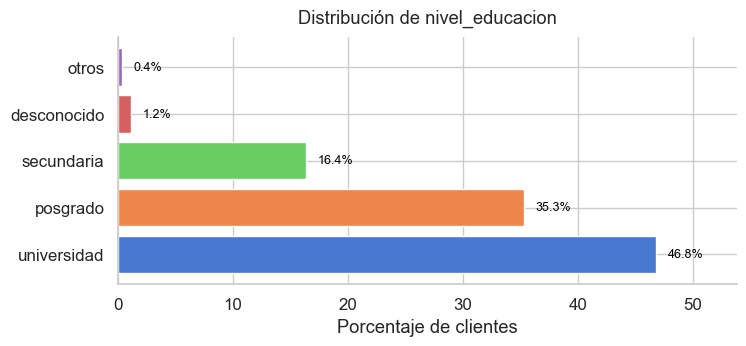

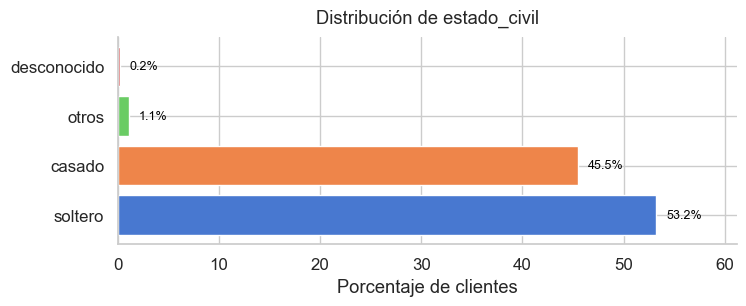

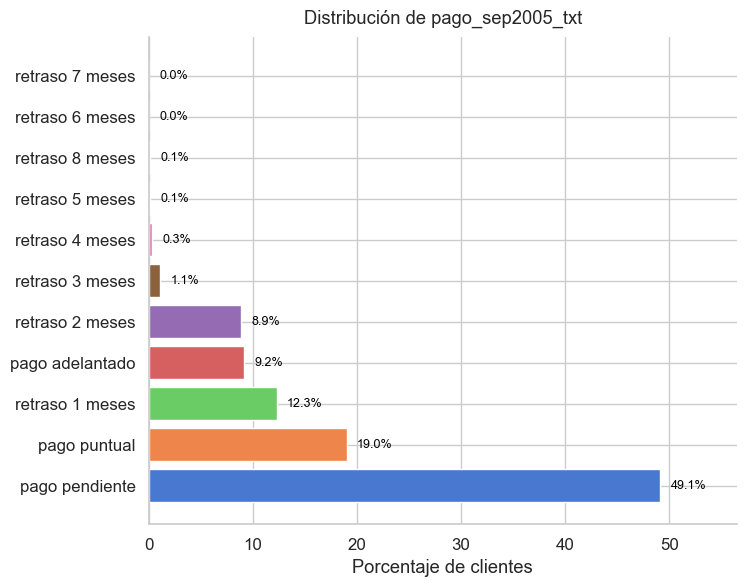

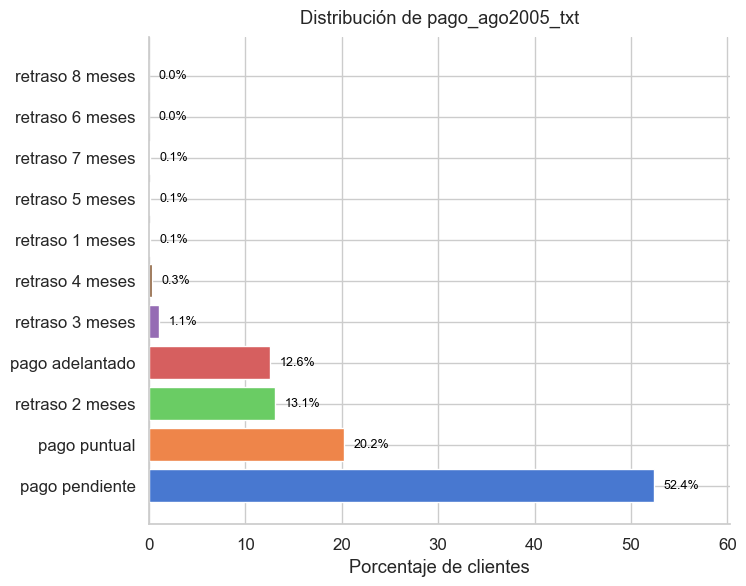

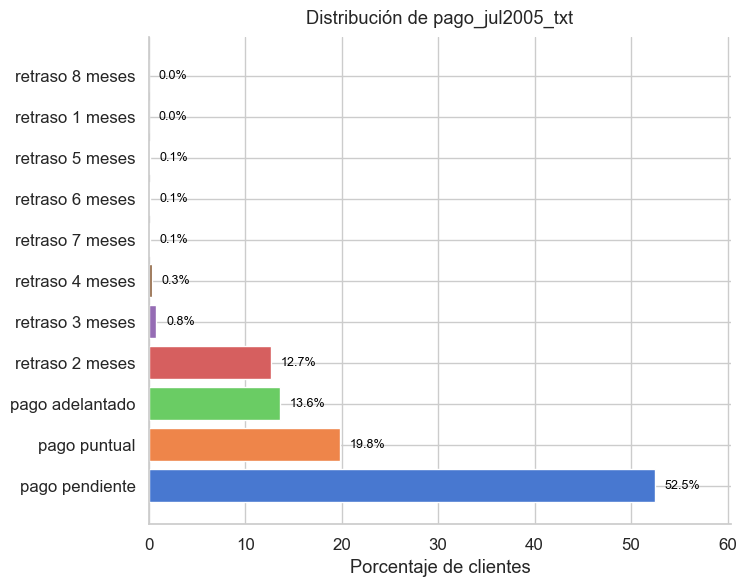

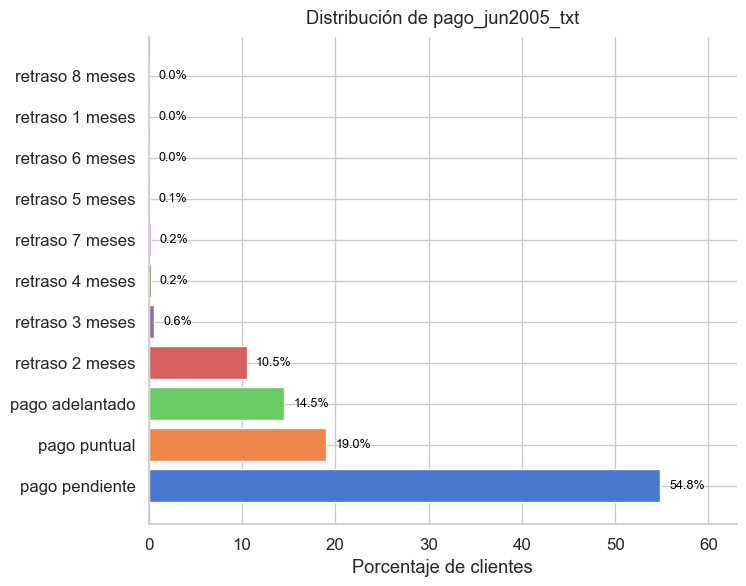

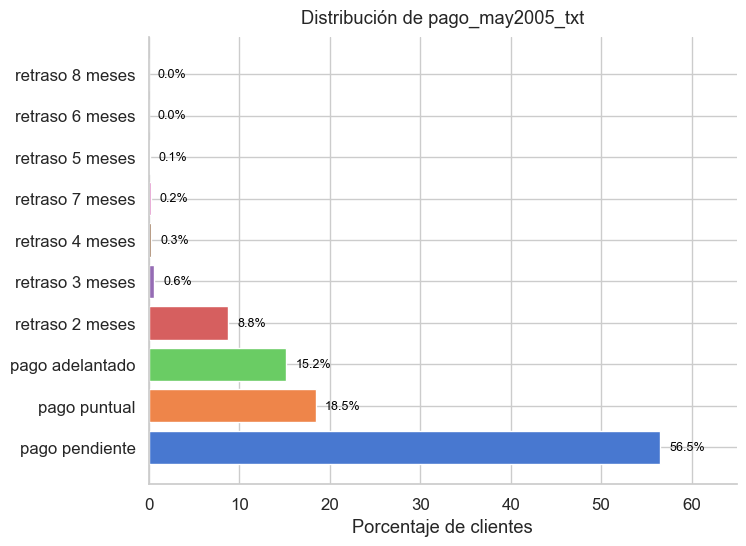

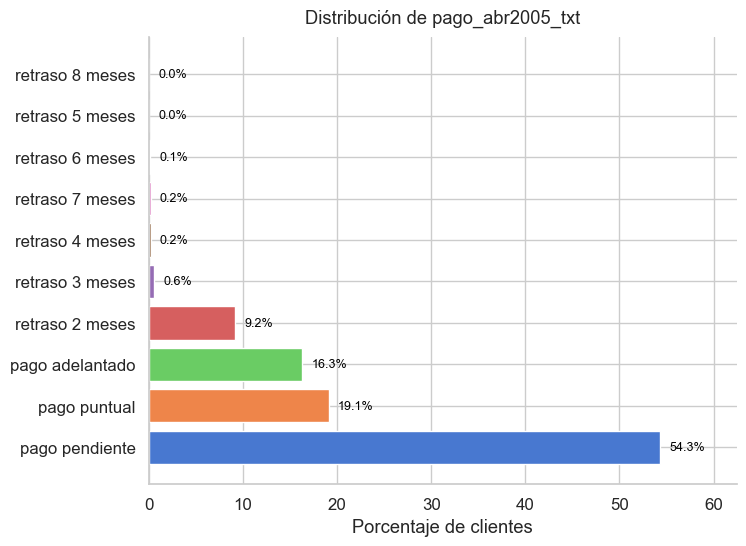

In [495]:
# Análisis univariado categórico

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

cat_vars = [
    c for c in df_limpio.select_dtypes(include=['object', 'category']).columns
    if c != 'incumplimiento_txt'
]

for col in cat_vars:
    counts = df_limpio[col].value_counts(dropna=False)
    pct    = (counts / counts.sum() * 100).round(1)

    # Orden descendente
    pct = pct.sort_values(ascending=False)

    # Ajusta alto según nº categorías
    alto = max(1, 0.4 * len(pct))
    fig, ax = plt.subplots(figsize=(8, alto + 2))

    colors = sns.color_palette("muted", len(pct))
    ax.barh(pct.index, pct.values, color=colors)

    # Etiquetas de porcentaje dentro/afuera según espacio
    for i, v in enumerate(pct.values):
        ax.text(v + 1, i, f"{v:.1f}%",
                va='center', color='black', fontsize=9)

    ax.set_title(f"Distribución de {col}", pad=10)
    ax.set_xlabel("Porcentaje de clientes")
    ax.set_ylabel("")
    ax.set_xlim(0, pct.max() * 1.15)

    plt.tight_layout(pad=2)
    plt.show()



In [496]:
# Validando cardinalidad y detección de niveles raros en variables categóricas

def reportar_cardinalidad_y_rareza(
    df: pd.DataFrame,
    cat_cols: list,
    umbral_rareza: float = 0.01
) -> pd.DataFrame:
    """
    Para cada variable categórica:
      • 'cardinalidad'  : nº de niveles (incluye NaN como nivel)
      • 'niveles_raros' : valores con frecuencia < umbral_rareza
    """
    registros = []

    for col in cat_cols:
        freq_rel = df[col].value_counts(normalize=True, dropna=False)
        raros = freq_rel[freq_rel < umbral_rareza].index.tolist()

        registros.append({
            "variable":     col,
            "cardinalidad": freq_rel.size,
            "niveles_raros": raros or ["Ninguno"]
        })

    return pd.DataFrame(registros)


# Aplicación
cat_vars = [
    c for c in df_limpio.select_dtypes(include=['object', 'category']).columns
    if c != 'incumplimiento_txt'
]

df_rareza = (
    reportar_cardinalidad_y_rareza(df_limpio, cat_vars, umbral_rareza=0.01)
      .sort_values("cardinalidad", ascending=False)
)

print(df_rareza.to_string(index=False))

        variable  cardinalidad                                                                                                           niveles_raros
pago_sep2005_txt            11                                   [retraso 4 meses, retraso 5 meses, retraso 8 meses, retraso 6 meses, retraso 7 meses]
pago_ago2005_txt            11                  [retraso 4 meses, retraso 1 meses, retraso 5 meses, retraso 7 meses, retraso 6 meses, retraso 8 meses]
pago_jul2005_txt            11 [retraso 3 meses, retraso 4 meses, retraso 7 meses, retraso 6 meses, retraso 5 meses, retraso 1 meses, retraso 8 meses]
pago_jun2005_txt            11 [retraso 3 meses, retraso 4 meses, retraso 7 meses, retraso 5 meses, retraso 6 meses, retraso 1 meses, retraso 8 meses]
pago_may2005_txt            10                  [retraso 3 meses, retraso 4 meses, retraso 7 meses, retraso 5 meses, retraso 6 meses, retraso 8 meses]
pago_abr2005_txt            10                  [retraso 3 meses, retraso 4 meses, retraso 7 m

In [497]:
# Columnas de historial de pago (ordinales)

# Historial de pago

pago_cols = [
    'pago_sep2005', 'pago_ago2005', 'pago_jul2005',
    'pago_jun2005', 'pago_may2005', 'pago_abr2005'
]

# Conversión a numérico
df_dccc[pago_cols] = df_dccc[pago_cols].apply(pd.to_numeric, errors='coerce')

# 2) Normalización de valores extremos
#    · < –2  →  –2   (adelantado)
#    ·  5…9  →   4   (retraso ≥ 4 meses)
df_dccc[pago_cols] = (
    df_dccc[pago_cols]
        .clip(lower=-2)                 # límite inferior
        .where(df_dccc[pago_cols] <= 4, 4)   # agrupar 5‑9 en 4
)

# Conversión a categoría ordinal coherente
cats = [-2, -1, 0, 1, 2, 3, 4]          # 4 = “retraso ≥4 meses”
ord_dtype = pd.CategoricalDtype(categories=cats, ordered=True)
df_dccc[pago_cols] = df_dccc[pago_cols].astype(ord_dtype)

# Variables derivadas

# Máximo retraso alcanzado
df_dccc['max_retraso'] = df_dccc[pago_cols].astype(int).max(axis=1)

# Promedio de retrasos
df_dccc['prom_retraso'] = (
    df_dccc[pago_cols].astype(int).mean(axis=1).astype('float32')
)

# Tendencia (pendiente simple) del historial
weights = np.arange(len(pago_cols))      # 0‑5 → meses más antiguos
norm = weights.sum()
df_dccc['tend_retraso'] = (
    df_dccc[pago_cols].astype(int).dot(weights) / norm
).astype('float32')

# Verificación rápida

print(
    df_dccc[pago_cols + ['max_retraso', 'prom_retraso', 'tend_retraso']]
      .head(10)
)

  pago_sep2005 pago_ago2005  ... prom_retraso tend_retraso
0            2            2  ...    -0.333333    -1.400000
1           -1            2  ...     0.500000     0.800000
2            0            0  ...     0.000000     0.000000
3            0            0  ...     0.000000     0.000000
4           -1            0  ...    -0.333333    -0.133333
5            0            0  ...     0.000000     0.000000
6            0            0  ...     0.000000     0.000000
7            0           -1  ...    -0.500000    -0.533333
8            0            0  ...     0.333333     0.266667
9           -2           -2  ...    -1.666667    -1.400000

[10 rows x 9 columns]


In [498]:
# Verificando valores únicos de pago_cols

# Valores únicos por columna de pago
for col in pago_cols:
    # Elimina niveles que nunca aparecen (por limpieza visual)
    df_dccc[col] = df_dccc[col].cat.remove_unused_categories()

    categorias = df_dccc[col].cat.categories.tolist()
    n_niveles  = len(categorias)           # cuenta real de categorías posibles

    print(f"\n>>> {col.upper()}")
    print("Valores únicos:", categorias)
    print(f"Cardinalidad:  {n_niveles} niveles")


>>> PAGO_SEP2005
Valores únicos: [-2, -1, 0, 1, 2, 3, 4]
Cardinalidad:  7 niveles

>>> PAGO_AGO2005
Valores únicos: [-2, -1, 0, 1, 2, 3, 4]
Cardinalidad:  7 niveles

>>> PAGO_JUL2005
Valores únicos: [-2, -1, 0, 1, 2, 3, 4]
Cardinalidad:  7 niveles

>>> PAGO_JUN2005
Valores únicos: [-2, -1, 0, 1, 2, 3, 4]
Cardinalidad:  7 niveles

>>> PAGO_MAY2005
Valores únicos: [-2, -1, 0, 2, 3, 4]
Cardinalidad:  6 niveles

>>> PAGO_ABR2005
Valores únicos: [-2, -1, 0, 2, 3, 4]
Cardinalidad:  6 niveles


In [499]:
# Aplicando mapeo a DataFrame original

# Diccionarios de mapeo
map_genero        = {1: 'hombre', 2: 'mujer'}
map_educacion     = {1: 'posgrado', 2: 'universidad', 3: 'secundaria', 4: 'otros'}
map_estado_civil  = {1: 'casado', 2: 'soltero', 3: 'otros'}
map_incumplimiento = {0: 'no incumple', 1: 'incumple'}

# Aplicar mapeos y marcar “desconocido” donde falte
df_dccc['genero']           = df_dccc['genero'].map(map_genero).fillna('desconocido')
df_dccc['nivel_educacion']  = df_dccc['nivel_educacion'].map(map_educacion).fillna('desconocido')
df_dccc['estado_civil']     = df_dccc['estado_civil'].map(map_estado_civil).fillna('desconocido')
df_dccc['incumplimiento_txt'] = df_dccc['incumplimiento'].map(map_incumplimiento)

# Convertir a categoría y fijar orden lógico
cat_cols = ['genero', 'nivel_educacion', 'estado_civil', 'incumplimiento_txt']
df_dccc[cat_cols] = df_dccc[cat_cols].astype('category')

edu_order = CategoricalDtype(
    categories=['desconocido', 'otros', 'secundaria', 'universidad', 'posgrado'],
    ordered=True
)
df_dccc['nivel_educacion'] = df_dccc['nivel_educacion'].astype(edu_order)

# Verificación
for col in cat_cols:
    cats = df_dccc[col].cat.categories.tolist()
    print(f"{col}: {len(cats)} categorías → {cats}")

genero: 2 categorías → ['hombre', 'mujer']
nivel_educacion: 5 categorías → ['desconocido', 'otros', 'secundaria', 'universidad', 'posgrado']
estado_civil: 4 categorías → ['casado', 'desconocido', 'otros', 'soltero']
incumplimiento_txt: 2 categorías → ['incumple', 'no incumple']



===== edad =====


,n,mean,std,median,q25,q75,test,p‑value
incumplimiento_txt,,,,,,,,
incumple,6636,35.73,9.69,34.0,28.0,42.0,Mann‑Whitney U,0.3725
no incumple,23364,35.42,9.08,34.0,28.0,41.0,Mann‑Whitney U,0.3725


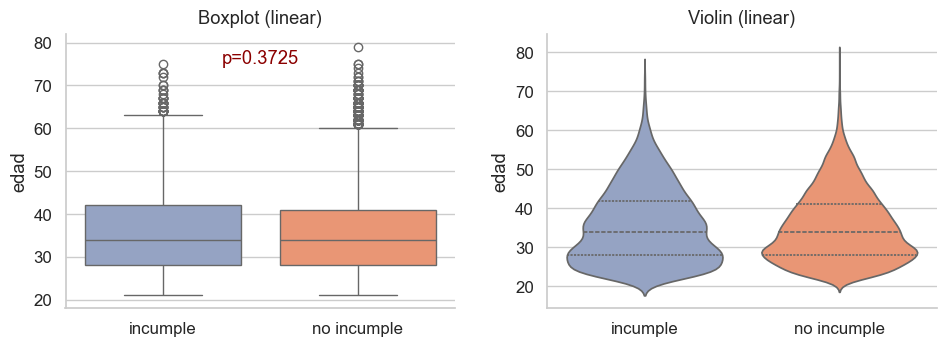


===== factura_abr2005 =====


,n,mean,std,median,q25,q75,test,p‑value
incumplimiento_txt,,,,,,,,
incumple,6636,38271.44,59579.67,18028.5,1150.0,47424.0,Mann‑Whitney U,0.9895
no incumple,23364,39042.27,59547.02,16679.0,1265.5,49842.5,Mann‑Whitney U,0.9895


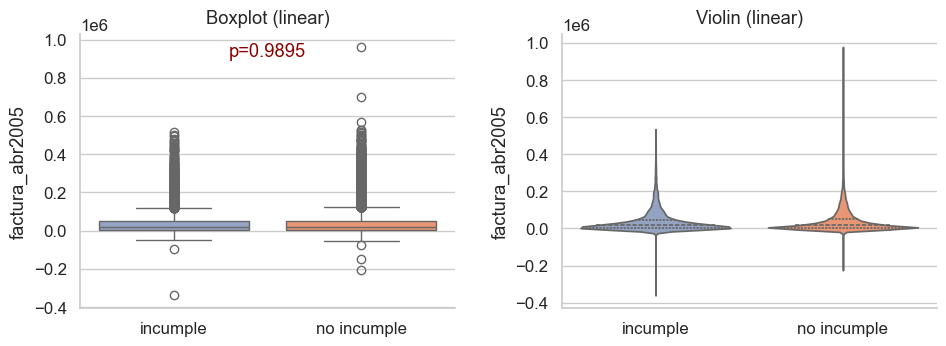


===== factura_ago2005 =====


,n,mean,std,median,q25,q75,test,p‑value
incumplimiento_txt,,,,,,,,
incumple,6636,47283.62,71651.03,20300.5,2694.0,57919.75,Mann‑Whitney U,0.0071
no incumple,23364,49717.44,71029.95,21660.5,3055.0,65686.00,Mann‑Whitney U,0.0071


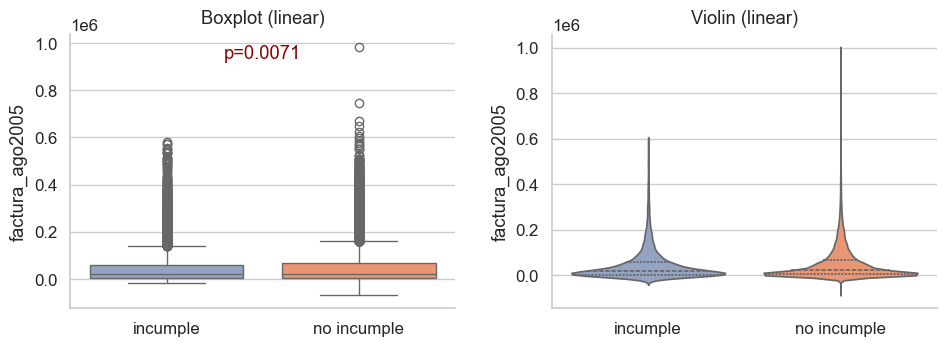


===== factura_jul2005 =====


,n,mean,std,median,q25,q75,test,p‑value
incumplimiento_txt,,,,,,,,
incumple,6636,45181.60,68516.98,19834.5,2500.00,54733.75,Mann‑Whitney U,0.0282
no incumple,23364,47533.37,69576.66,20202.5,2769.75,61894.00,Mann‑Whitney U,0.0282


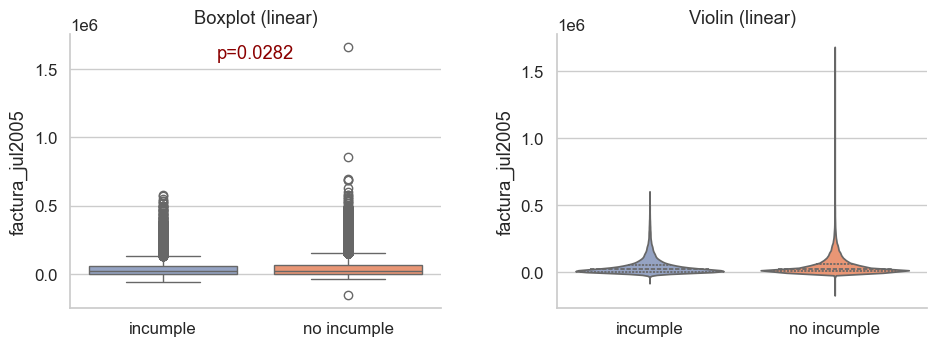


===== factura_jun2005 =====


,n,mean,std,median,q25,q75,test,p‑value
incumplimiento_txt,,,,,,,,
incumple,6636,42036.95,64351.08,19119.5,2141.5,50175.75,Mann‑Whitney U,0.1478
no incumple,23364,43611.17,64324.80,19000.0,2360.0,55988.00,Mann‑Whitney U,0.1478


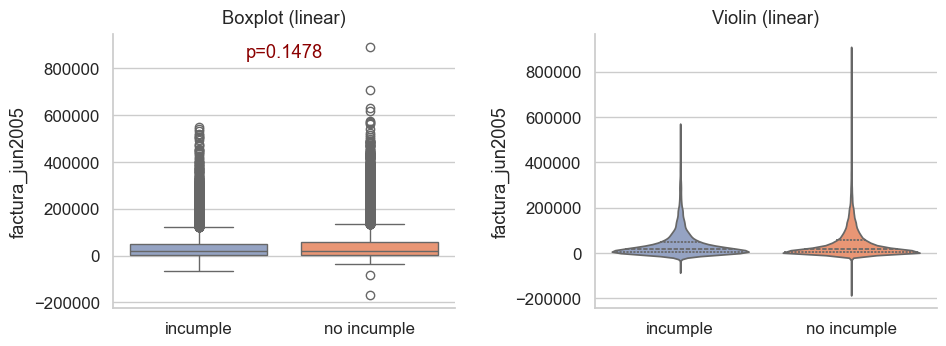


===== factura_may2005 =====


,n,mean,std,median,q25,q75,test,p‑value
incumplimiento_txt,,,,,,,,
incumple,6636,39540.19,61424.70,18478.5,1502.75,47853.00,Mann‑Whitney U,0.2354
no incumple,23364,40530.45,60617.27,17998.0,1823.00,51135.25,Mann‑Whitney U,0.2354


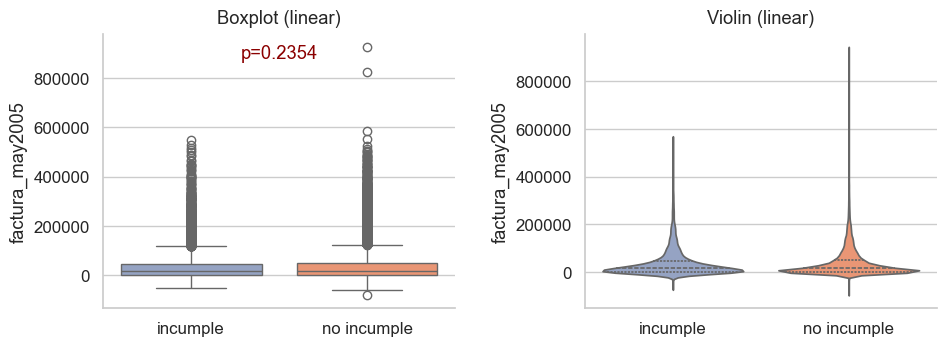


===== factura_sep2005 =====


,n,mean,std,median,q25,q75,test,p‑value
incumplimiento_txt,,,,,,,,
incumple,6636,48509.16,73782.07,20185.0,2987.75,59626.5,Mann‑Whitney U,0.0
no incumple,23364,51994.23,73577.61,23119.5,3677.25,69027.0,Mann‑Whitney U,0.0


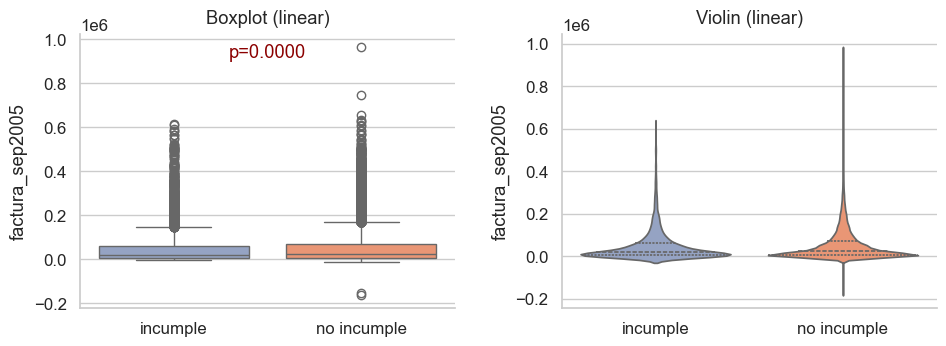


===== max_retraso =====


,n,mean,std,median,q25,q75,test,p‑value
incumplimiento_txt,,,,,,,,
incumple,6636,1.23,1.40,2.0,0.0,2.0,Mann‑Whitney U,0.0
no incumple,23364,0.20,1.16,0.0,0.0,0.0,Mann‑Whitney U,0.0


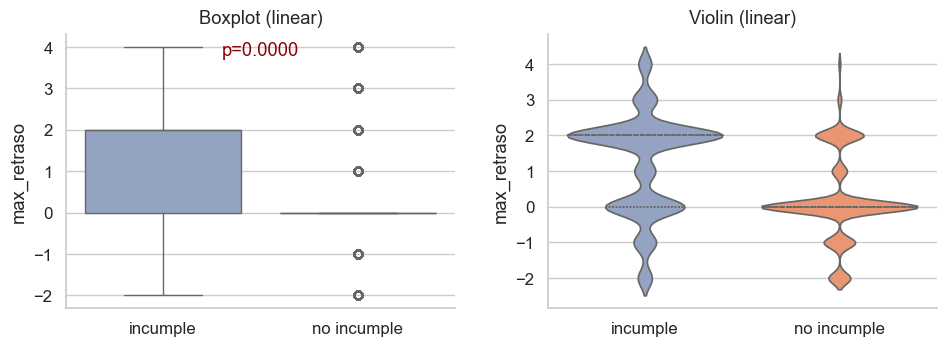


===== monto_credito =====


,n,mean,std,median,q25,q75,test,p‑value
incumplimiento_txt,,,,,,,,
incumple,6636,130109.66,115378.54,90000.0,50000.0,200000.0,Mann‑Whitney U,0.0
no incumple,23364,178099.73,131628.36,150000.0,70000.0,250000.0,Mann‑Whitney U,0.0


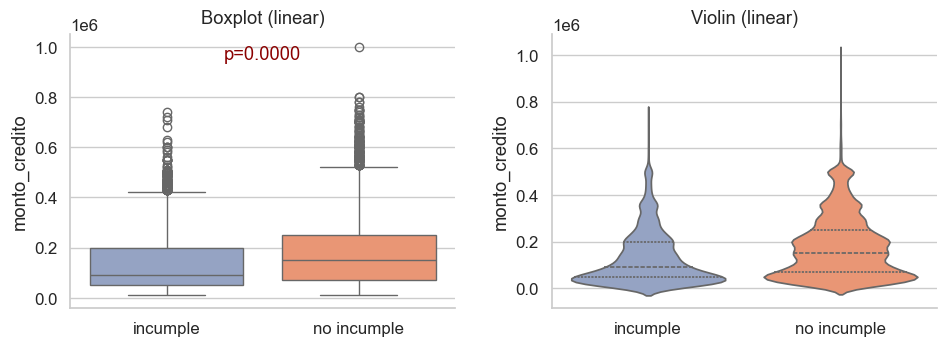


===== pagado_abr2005 =====


,n,mean,std,median,q25,q75,test,p‑value
incumplimiento_txt,,,,,,,,
incumple,6636,3441.48,13464.01,1000.0,0.0,2974.5,Mann‑Whitney U,0.0
no incumple,23364,5719.37,18792.95,1706.0,300.0,4545.0,Mann‑Whitney U,0.0


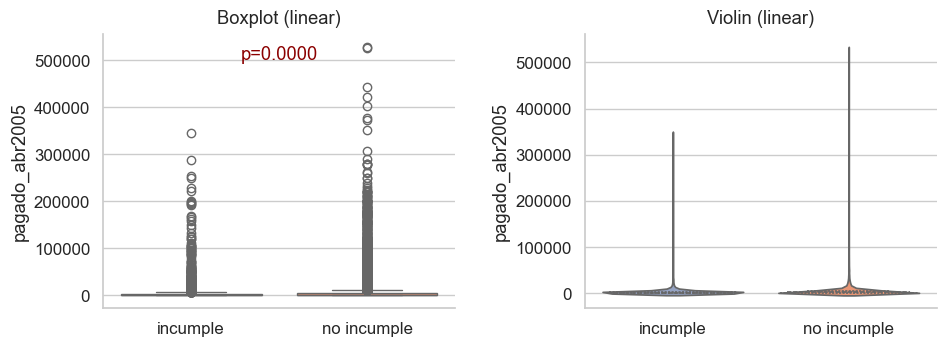


===== pagado_ago2005 =====


,n,mean,std,median,q25,q75,test,p‑value
incumplimiento_txt,,,,,,,,
incumple,6636,3388.65,11737.99,1533.5,0.0,3309.75,Mann‑Whitney U,0.0
no incumple,23364,6640.47,25302.26,2247.5,1005.0,5311.25,Mann‑Whitney U,0.0


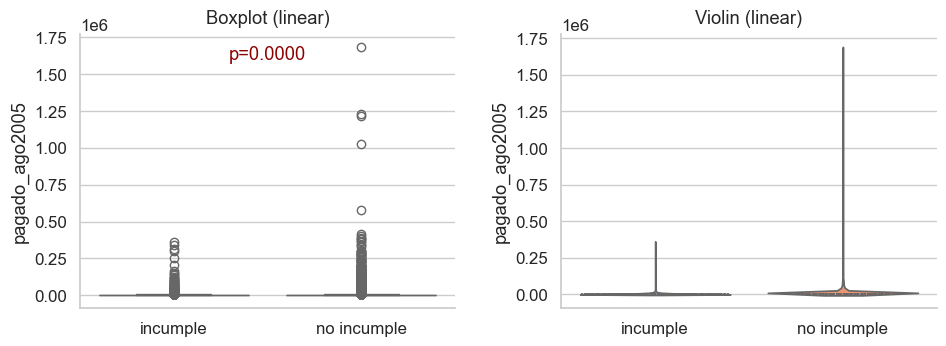


===== pagado_jul2005 =====


,n,mean,std,median,q25,q75,test,p‑value
incumplimiento_txt,,,,,,,,
incumple,6636,3367.35,12959.62,1222.0,0.0,3000.0,Mann‑Whitney U,0.0
no incumple,23364,5753.50,18684.26,2000.0,600.0,5000.0,Mann‑Whitney U,0.0


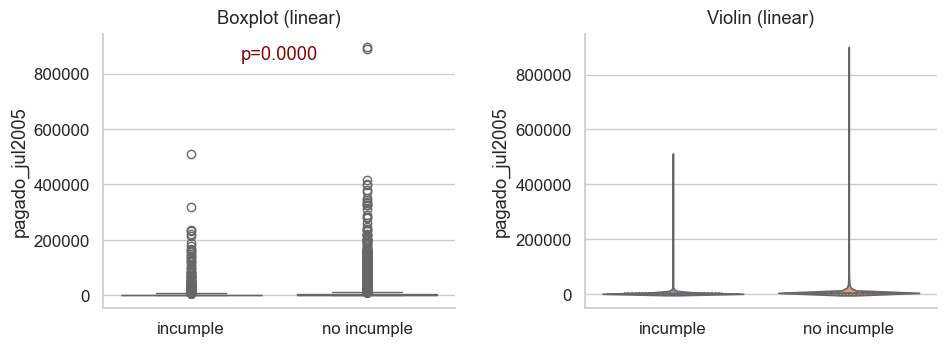


===== pagado_jun2005 =====


,n,mean,std,median,q25,q75,test,p‑value
incumplimiento_txt,,,,,,,,
incumple,6636,3155.63,11191.97,1000.0,0.0,2939.25,Mann‑Whitney U,0.0
no incumple,23364,5300.53,16689.78,1734.0,390.0,4602.00,Mann‑Whitney U,0.0


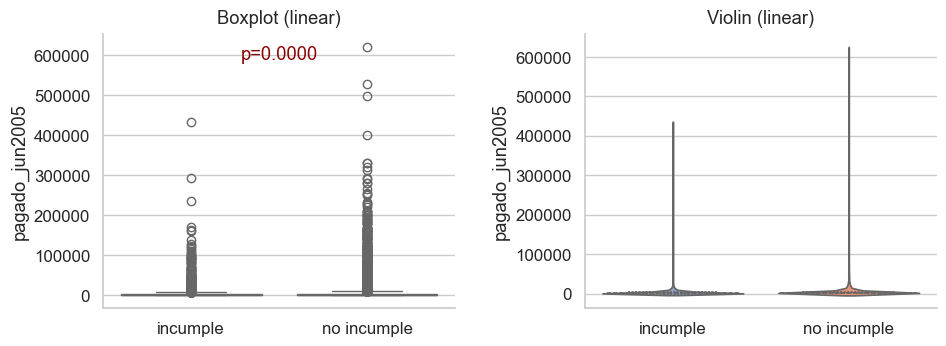


===== pagado_may2005 =====


,n,mean,std,median,q25,q75,test,p‑value
incumplimiento_txt,,,,,,,,
incumple,6636,3219.14,11944.73,1000.0,0.0,3000.0,Mann‑Whitney U,0.0
no incumple,23364,5248.22,16071.67,1765.0,369.0,4600.0,Mann‑Whitney U,0.0


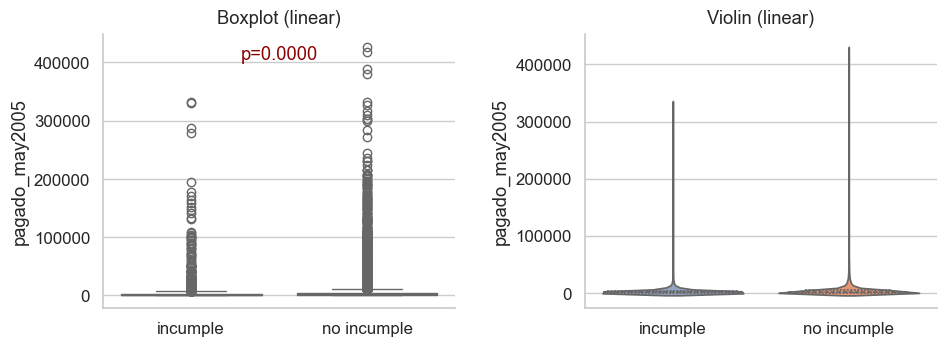


===== pagado_sep2005 =====


,n,mean,std,median,q25,q75,test,p‑value
incumplimiento_txt,,,,,,,,
incumple,6636,3397.04,9544.25,1636.0,0.00,3478.25,Mann‑Whitney U,0.0
no incumple,23364,6307.34,18014.51,2459.5,1163.75,5606.25,Mann‑Whitney U,0.0


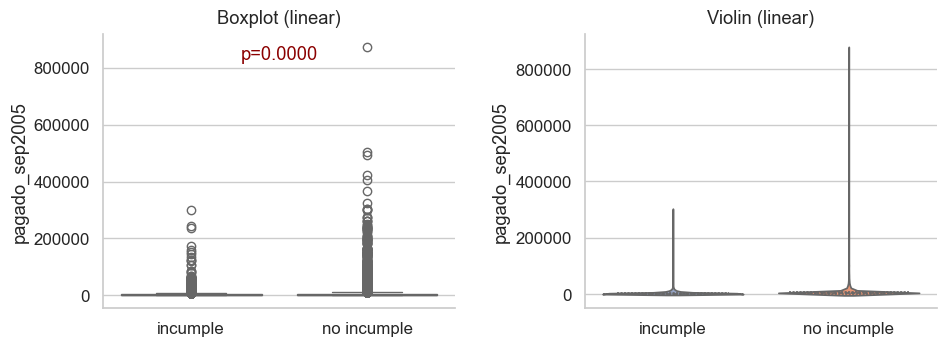


===== prom_retraso =====


,n,mean,std,median,q25,q75,test,p‑value
incumplimiento_txt,,,,,,,,
incumple,6636,0.32,1.18,0.33,-0.50,1.17,Mann‑Whitney U,0.0
no incumple,23364,-0.33,0.83,0.00,-0.83,0.00,Mann‑Whitney U,0.0


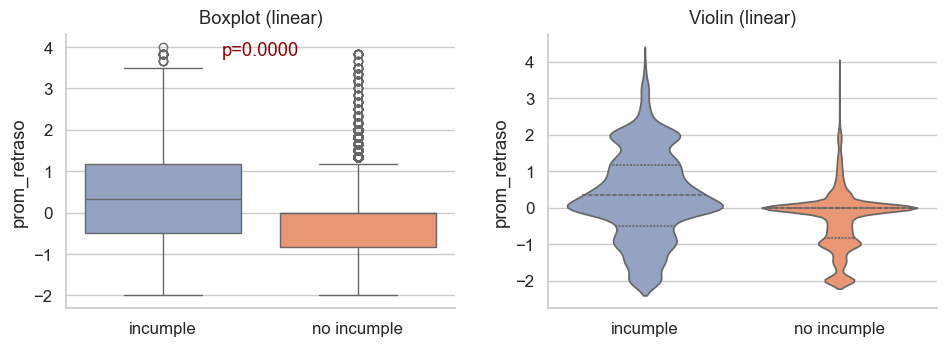


===== tend_retraso =====


,n,mean,std,median,q25,q75,test,p‑value
incumplimiento_txt,,,,,,,,
incumple,6636,0.19,1.26,0.0,-0.6,0.8,Mann‑Whitney U,0.0
no incumple,23364,-0.37,0.88,0.0,-1.0,0.0,Mann‑Whitney U,0.0


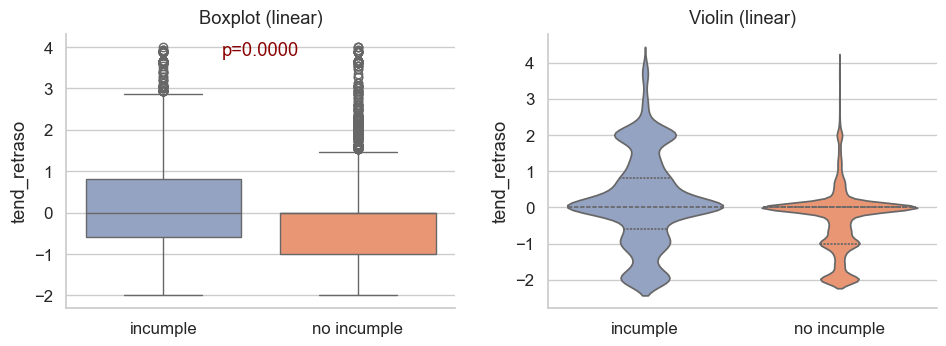

In [500]:
# Generando gráficos boxplot y violinplot para comparar grupos

# Estilo global
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.1)
plt.rcParams.update({'axes.spines.top': False,
                     'axes.spines.right': False,
                     'figure.dpi': 100})

# Resumen estadístico + test paramétrico / no‑param
def resumen_grupos(df, var, grupo='incumplimiento_txt'):
    g = df.groupby(grupo, observed=True)[var]
    tabla = g.agg(n='size', mean='mean', std='std',
                  median='median',
                  q25=lambda x: x.quantile(.25),
                  q75=lambda x: x.quantile(.75)).round(2)

    # Extraemos las dos series a comparar
    cat_vals = tabla.index.tolist()
    s0, s1 = (df[df[grupo] == k][var] for k in cat_vals)

    # Comprobaciones mínimas para elegir test
    min_n = min(len(s0), len(s1))
    norm_ok = min_n >= 8 and normaltest(s0).pvalue > .05 and normaltest(s1).pvalue > .05
    var_equal = levene(s0, s1).pvalue > .05 if min_n >= 2 else False

    if norm_ok and var_equal:
        _, pval = ttest_ind(s0, s1, equal_var=True)
        test = 't‑test'
    else:
        _, pval = mannwhitneyu(s0, s1, alternative='two-sided')
        test = 'Mann‑Whitney U'

    tabla['test'] = test
    tabla['p‑value'] = round(pval, 4)
    return tabla


# Boxplot + Violinplot comparativo
def plot_comparativo(df, var, grupo='incumplimiento_txt'):
    p_txt = f"p={resumen_grupos(df, var, grupo)['p‑value'].iloc[0]:.4f}"

    serie = df[var].dropna()
    use_log = abs(serie.skew()) > 1 and serie.min() > 0
    scale = 'log' if use_log else 'linear'

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    pal = ["#8DA0CB", "#FC8D62"]

    sns.boxplot(x=grupo, y=var, data=df, hue=grupo,
                palette=pal, dodge=False, ax=ax0)
    sns.violinplot(x=grupo, y=var, data=df, hue=grupo,
                   palette=pal, dodge=False, inner='quartile', ax=ax1)

    # Eliminar leyendas sólo si existen
    for ax in (ax0, ax1):
        leg = ax.get_legend()
        if leg:
            leg.remove()
        ax.set_xlabel('')
        ax.set_yscale(scale)

    # Etiquetas y títulos
    ax0.set_title(f"Boxplot ({scale})", pad=8)
    ax1.set_title(f"Violin ({scale})", pad=8)
    ax0.text(.5, serie.max()*0.95, p_txt,
             ha='center', color='darkred')

    plt.tight_layout(pad=2)
    plt.show()


# Ejecutar sobre todas las numéricas
num_cols = (df_dccc.select_dtypes(include='number')
            .columns.difference(['cliente_id', 'incumplimiento']))

for col in num_cols:
    print(f"\n===== {col} =====")
    display(resumen_grupos(df_dccc, col))
    plot_comparativo(df_dccc, col)


In [501]:
# Copia de trabajo
df   = df_dccc.copy()
y    = df['incumplimiento']
num_cols = df.select_dtypes(include='number') \
             .columns.difference(['cliente_id', 'incumplimiento'])

resultados = []

for col in num_cols:
    x = df[col]

    # Eliminar filas con NaN en x o y
    mask = x.notna() & y.notna()
    x_cln = x[mask]
    y_cln = y[mask]

    # Separar grupos
    g0 = x_cln[y_cln == 0]
    g1 = x_cln[y_cln == 1]

    # Normalidad (si n≥8) en muestra recortada al tamaño del grupo menor
    n_min = min(len(g0), len(g1))
    n_test = min(n_min, 5000)               # no muestres >5000 para evitar coste
    s0 = g0.sample(n_test, random_state=42) if len(g0) > n_test else g0
    s1 = g1.sample(n_test, random_state=42) if len(g1) > n_test else g1
    p_norm0 = normaltest(s0).pvalue if len(s0) >= 8 else np.nan
    p_norm1 = normaltest(s1).pvalue if len(s1) >= 8 else np.nan

    # Homogeneidad de varianzas
    if g0.var() == 0 or g1.var() == 0:
        p_levene = np.nan
    else:
        p_levene = levene(g0, g1).pvalue

    # Selección de método de correlación
    if (p_norm0 > .05) and (p_norm1 > .05) and (p_levene > .05):
        metodo = 'point‑biserial'
        corr, p_corr = pointbiserialr(y_cln, x_cln)
    else:
        metodo = 'Spearman'
        corr, p_corr = spearmanr(y_cln, x_cln)

    resultados.append({
        'variable': col,
        'n': len(x_cln),
        'p_norm_0': round(p_norm0, 4) if not np.isnan(p_norm0) else '—',
        'p_norm_1': round(p_norm1, 4) if not np.isnan(p_norm1) else '—',
        'p_levene': round(p_levene, 4) if not np.isnan(p_levene) else '—',
        'método':   metodo,
        'corr':     round(corr, 4),
        'p_corr':   round(p_corr, 4)
    })

# Tabla ordenada por |corr|
tabla = (pd.DataFrame(resultados)
         .set_index('variable')
         .sort_values('corr', key=lambda s: s.abs(), ascending=False))

display(tabla)

,n,p_norm_0,p_norm_1,p_levene,método,corr,p_corr
variable,,,,,,,
max_retraso,30000,0.0,0.0,0.0000,Spearman,0.3210,0.0000
prom_retraso,30000,0.0,0.0,0.0000,Spearman,0.2563,0.0000
tend_retraso,30000,0.0,0.0,0.0000,Spearman,0.2146,0.0000
monto_credito,30000,0.0,0.0,0.0000,Spearman,-0.1696,0.0000
pagado_sep2005,30000,0.0,0.0,0.0000,Spearman,-0.1605,0.0000
pagado_ago2005,30000,0.0,0.0,0.0000,Spearman,-0.1510,0.0000
pagado_jul2005,30000,0.0,0.0,0.0000,Spearman,-0.1394,0.0000
pagado_jun2005,30000,0.0,0.0,0.0000,Spearman,-0.1280,0.0000
pagado_abr2005,30000,0.0,0.0,0.0000,Spearman,-0.1214,0.0000


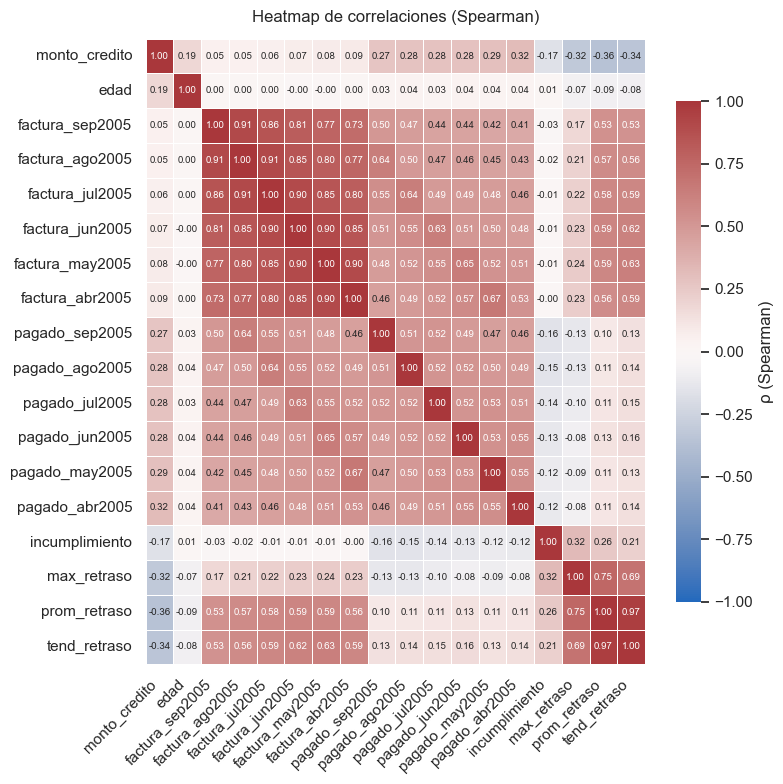

In [502]:
# Visualización de correlaciones entre variables numéricas

# Preparación de datos
df_num = (df_dccc
          .select_dtypes(include='number')
          .drop(columns=['cliente_id'], errors='ignore'))

# Matriz de correlación Spearman
corr = df_num.corr(method='spearman').fillna(0)

# Ajuste dinámico de parámetros de la figura
n_vars = corr.shape[0]
annot_flag = n_vars <= 25

# Escalamos el tamaño: 0.4 × n_vars parece legible
fig_w = max(8, 0.4 * n_vars)
fig_h = fig_w

sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.0)
plt.rcParams.update({'axes.spines.top': False,
                     'axes.spines.right': False,
                     'figure.dpi': 100})

# Heatmap
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

sns.heatmap(
    corr,
    cmap='vlag', center=0, vmin=-1, vmax=1,
    annot=annot_flag, fmt=".2f", annot_kws={"size": 7},
    linewidths=0.4,
    cbar_kws={"shrink": 0.8, "label": "ρ (Spearman)"}
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title("Heatmap de correlaciones (Spearman)", pad=12)

plt.tight_layout()
plt.show()

In [503]:
# Análisis univariante de variables numéricas con AUC

# Variables numéricas sin ID ni target, excluyendo constantes

num_vars = [c for c in df_dccc.columns
            if pd.api.types.is_numeric_dtype(df_dccc[c])
            and c not in ('cliente_id', 'incumplimiento')
            and df_dccc[c].nunique(dropna=True) > 1]

y = df_dccc['incumplimiento']
auc_rows = []

for col in num_vars:
    # Imputación simple
    x = df_dccc[col].fillna(df_dccc[col].median())

    # Asegurar que queden al menos 2 valores únicos
    if x.nunique() < 2:
        continue

    # Calcular AUC (puede devolver <0.5 si asociación es inversa)
    auc = roc_auc_score(y, x)

    auc_rows.append({
        'variable': col,
        'AUC': round(auc, 3),
        'sentido': 'directo' if auc >= 0.5 else 'inverso'
    })

auc_df = (pd.DataFrame(auc_rows)
          .set_index('variable')
          .sort_values('AUC', ascending=False))

print("AUC univariante (sin forzar signo):")
display(auc_df)


AUC univariante (sin forzar signo):


,AUC,sentido
variable,,
max_retraso,0.708,directo
prom_retraso,0.675,directo
tend_retraso,0.646,directo
edad,0.504,directo
factura_abr2005,0.500,inverso
factura_may2005,0.495,inverso
factura_jun2005,0.494,inverso
factura_jul2005,0.491,inverso
factura_ago2005,0.489,inverso


In [504]:
# Análisis bivariado de variables categóricas con Cramér’s V

# Variables categóricas a evaluar
cat_vars = (
    df_dccc.select_dtypes(include=['object', 'category'])
           .columns.difference(['incumplimiento_txt'])
)

def cramers_v_corrected(ct: pd.DataFrame):
    """Cramér’s V corregido (Bergsma & Wicher). Devuelve V y p‑value χ²."""
    chi2, p, dof, expected = chi2_contingency(ct, correction=False)
    n = ct.values.sum()
    phi2 = chi2 / n
    r, k = ct.shape

    # Corrección de sesgo
    phi2_corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)

    if min(kcorr - 1, rcorr - 1) == 0:
        return np.nan, p, expected  # división imposible
    v_corr = np.sqrt(phi2_corr / min(kcorr - 1, rcorr - 1))
    return v_corr, p, expected

# Cálculo
rows = []
for col in cat_vars:
    # Tabla de contingencia
    ct = pd.crosstab(df_dccc[col], df_dccc['incumplimiento'])
    ct = ct.loc[(ct.sum(axis=1) > 0)]          # quita filas vacías

    if ct.shape[0] < 2:        # sólo 1 nivel
        continue

    v, p, exp = cramers_v_corrected(ct)

    # % de celdas con expected < 5 (fiabilidad χ²)
    low_exp_pct = (exp < 5).mean() * 100

    rows.append({
        'variable': col,
        'niveles':  ct.shape[0],
        "Cramér's V": round(v, 3) if not np.isnan(v) else '—',
        'p_χ²':      round(p, 4),
        '% exp<5':   f"{low_exp_pct:.1f}%"
    })

resumen_chi2 = (
    pd.DataFrame(rows)
      .set_index('variable')
      .sort_values("Cramér's V", key=lambda s: pd.to_numeric(s, errors='coerce').fillna(0), ascending=False)
)

display(resumen_chi2)


,niveles,Cramér's V,p_χ²,% exp<5
variable,,,,
pago_sep2005,7,0.422,0.0,0.0%
pago_ago2005,7,0.340,0.0,0.0%
pago_jul2005,7,0.295,0.0,14.3%
pago_jun2005,7,0.278,0.0,14.3%
pago_may2005,6,0.270,0.0,0.0%
pago_abr2005,6,0.250,0.0,0.0%
nivel_educacion,5,0.072,0.0,0.0%
genero,2,0.040,0.0,0.0%
estado_civil,4,0.033,0.0,0.0%


In [505]:
# Aplicando Feature Engineering a las variables seleccionadas

#  Feature Engineering 

df = df_dccc.copy()

# Variables base
base_feats = ["prom_retraso", "tend_retraso", "monto_credito", 
              "pago_sep2005",'pago_ago2005', 'pago_jul2005',"max_retraso"]

# Uso de línea de crédito
fact_cols = [f"factura_{m}" for m in
             ["sep2005","ago2005","jul2005","jun2005","may2005","abr2005"]]

ratio_bill = (
    df[fact_cols]
      .div(df["monto_credito"], axis=0)
      .clip(upper=1)
      .fillna(0)
)

df["util_mean"]      = ratio_bill.mean(axis=1)
df["util_max"]       = ratio_bill.max(axis=1)
df["util_std"]       = ratio_bill.std(axis=1)

def row_slope(arr):
    arr = np.asarray(arr, dtype="float64")
    msk = np.isfinite(arr)
    if msk.sum() < 3:
        return np.nan
    return np.polyfit(np.arange(msk.size)[msk], arr[msk], 1)[0]

df["util_trend"]     = ratio_bill.apply(row_slope, axis=1).astype("float32")
df["util_months_90"] = (ratio_bill >= 0.90).sum(axis=1).astype("int8")

# Disciplina de pago
pay_cols = [f"pagado_{m}" for m in
            ["sep2005","ago2005","jul2005","jun2005","may2005","abr2005"]]

ratio_pay = (
    df[pay_cols]
      .div(df[fact_cols].replace(0, np.nan), axis=0)
      .replace(np.inf, 2)     # evita infinitos
      .fillna(0)
      .clip(upper=2)
)

df["pay_ratio_mean"]  = ratio_pay.mean(axis=1)
df["pay_ratio_min"]   = ratio_pay.min(axis=1)
df["pay_ratio_std"]   = ratio_pay.std(axis=1)
df["pay_ratio_max"]   = ratio_pay.max(axis=1)

df["pay_full_pct"]    = (ratio_pay >= 1).mean(axis=1).astype("float32")
df["pay_ratio_trend"] = ratio_pay.apply(row_slope, axis=1).astype("float32")
df["pay_ratio_cv"]    = (ratio_pay.std(axis=1) /
                         (ratio_pay.mean(axis=1) + 1e-6)).astype("float32")

# Dinámica de morosidad
delay_cols = [f"pago_{m}" for m in
              ["sep2005","ago2005","jul2005","jun2005","may2005","abr2005"]]

hist_pago = df[delay_cols].astype(int).to_numpy()
df["delay_escalation_flag"] = (np.diff(hist_pago, axis=1) > 0)\
                                .any(axis=1).astype("int8")

delay_num = df[delay_cols].astype(int)
df["delay_months_pos"]   = (delay_num > 0).sum(axis=1).astype("int8")
df["severe_delay_flag"]  = (delay_num >= 2).any(axis=1).astype("int8")

def longest_positive_streak(v):
    best = streak = 0
    for val in v:
        streak = streak + 1 if val > 0 else 0
        best   = max(best, streak)
    return best

df["delay_longest_streak"] = delay_num.apply(longest_positive_streak,
                                             axis=1).astype("int8")

# No linealidad de crédito
df["log_monto_credito"] = np.log1p(df["monto_credito"])

# Listas de nuevas variables
new_feats = [
    "util_mean","util_max","util_std",
    "pay_ratio_mean","pay_ratio_min","pay_ratio_std","pay_ratio_max",
    "delay_escalation_flag"
]

extra_feats = [
    "util_trend","util_months_90",
    "pay_full_pct","pay_ratio_trend","pay_ratio_cv",
    "delay_months_pos","severe_delay_flag","delay_longest_streak",
    "log_monto_credito"
]

# Selección univariante (AUC)
selected = []
for feat in base_feats + new_feats + extra_feats:
    ser = df[feat]
    if isinstance(ser.dtype, CategoricalDtype):
        ser = ser.astype(int)
    if ser.nunique() < 2:
        continue

    auc = roc_auc_score(df["incumplimiento"], ser)

    if auc >= 0.55:
        selected.append(feat)
    elif auc <= 0.45:
        rng = ser.max() - ser.min()
        if rng > 0:
            df[f"{feat}_inv"] = 1 - (ser - ser.min()) / rng
            selected.append(f"{feat}_inv")

# Dataset final
cat_sel   = ["nivel_educacion", "genero", "estado_civil"]
final_cols = ["cliente_id", "incumplimiento"] + selected + cat_sel

df_final = pd.get_dummies(
    df[final_cols],
    columns=cat_sel,
    drop_first=True,
    dtype="uint8"
)

print("Shape final:", df_final.shape)
display(df_final.head())


Shape final: (30000, 24)


,cliente_id,incumplimiento,prom_retraso,tend_retraso,monto_credito_inv,pago_sep2005,pago_ago2005,pago_jul2005,max_retraso,util_mean,delay_escalation_flag,util_trend,delay_months_pos,severe_delay_flag,delay_longest_streak,log_monto_credito_inv,nivel_educacion_otros,nivel_educacion_secundaria,nivel_educacion_universidad,nivel_educacion_posgrado,genero_mujer,estado_civil_desconocido,estado_civil_otros,estado_civil_soltero
0,1,1,-0.333333,-1.400000,0.989899,2,2,-1,2,0.064200,0,-0.042229,2,1,2,0.849493,0,0,1,0,1,0,0,0
1,2,1,0.500000,0.800000,0.888889,-1,2,0,2,0.023718,1,0.002065,2,1,1,0.460418,0,0,1,0,1,0,0,1
2,3,0,0.000000,0.000000,0.919192,0,0,0,0,0.188246,0,-0.020608,0,0,0,0.522888,0,0,1,0,1,0,0,1
3,4,0,0.000000,0.000000,0.959596,0,0,0,0,0.771113,0,-0.094865,0,0,0,0.650525,0,0,1,0,1,0,0,0
4,5,0,-0.333333,-0.133333,0.959596,-1,0,-1,0,0.364463,1,0.044630,0,0,0,0.650525,0,0,1,0,0,0,0,0


In [506]:
# Definiendo el listado completo de variables candidatas

# Tomamos la versión _inv cuando corresponde
final_feats = []
for feat in selected:
    if f"{feat}_inv" in df.columns:
        final_feats.append(f"{feat}_inv")
    else:
        final_feats.append(feat)

rows = []
for feat in final_feats:
    serie = df[feat]
    if isinstance(serie.dtype, CategoricalDtype):
        serie = serie.astype(int)
    auc = roc_auc_score(df['incumplimiento'], serie)
    motivo = (
        "invertida"   if feat.endswith("_inv") else
        "seleccionada"
    )
    rows.append({
        "variable": feat,
        "AUC": round(auc, 3),
        "motivo": motivo
    })

auc_summary = (
    pd.DataFrame(rows)
      .set_index("variable")
      .sort_values("AUC", ascending=False)
)

print("### Resumen definitivo de variables seleccionadas")
display(auc_summary)

### Resumen definitivo de variables seleccionadas


,AUC,motivo
variable,,
delay_months_pos,0.726,seleccionada
delay_longest_streak,0.724,seleccionada
max_retraso,0.708,seleccionada
severe_delay_flag,0.696,seleccionada
pago_sep2005,0.690,seleccionada
prom_retraso,0.675,seleccionada
tend_retraso,0.646,seleccionada
pago_ago2005,0.639,seleccionada
pago_jul2005,0.624,seleccionada


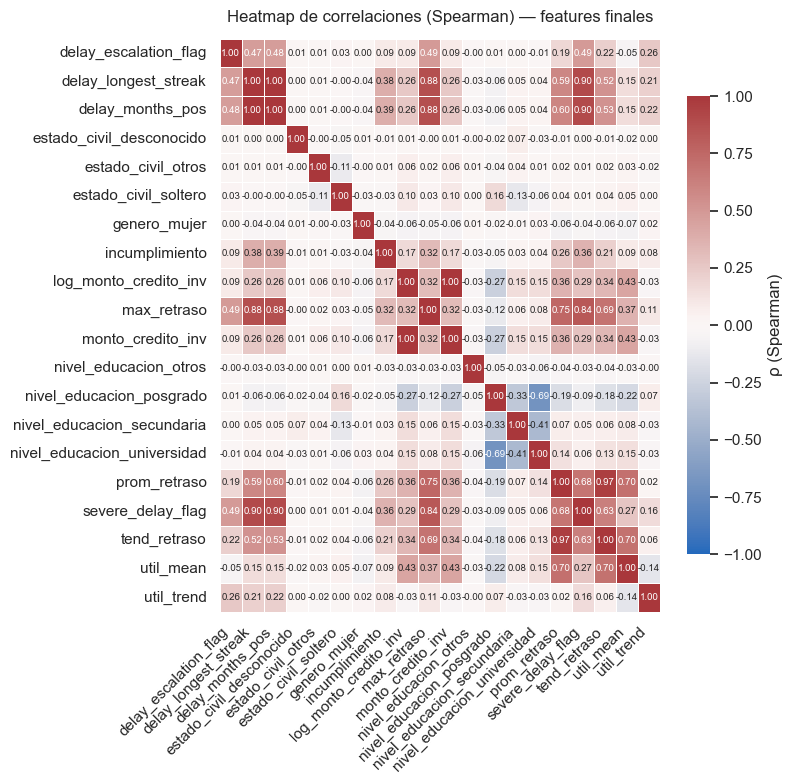


Pares con |ρ| ≥ 0.80:
                 var1              var2     corr
 delay_longest_streak  delay_months_pos 0.998347
 delay_longest_streak       max_retraso 0.877744
 delay_longest_streak severe_delay_flag 0.899319
     delay_months_pos       max_retraso 0.878014
     delay_months_pos severe_delay_flag 0.902345
log_monto_credito_inv monto_credito_inv 1.000000
          max_retraso severe_delay_flag 0.835036
         prom_retraso      tend_retraso 0.966081

Recomendaciones para multicolinealidad:
                 var1              var2  corr                  keep                 drop                                                                           motivo
 delay_longest_streak  delay_months_pos 0.998      delay_months_pos delay_longest_streak   |ρ|=1.00 ≥0.80 → AUC(delay_months_pos)=0.726 > AUC(delay_longest_streak)=0.724
 delay_longest_streak       max_retraso 0.878  delay_longest_streak          max_retraso        |ρ|=0.88 ≥0.80 → AUC(delay_longest_streak)=0.724 > AUC(max_

In [507]:
# Generando matriz de correlación con nuevas feature

# Preparar DataFrame numérico

df = df_final.copy()

num_cols = (
    df.select_dtypes(include='number')
      .columns.difference(['cliente_id'])
)

# quitar columnas constantes para evitar NaN en correlación

constantes = [c for c in num_cols if df[c].nunique() < 2]
num_cols = [c for c in num_cols if c not in constantes]

# Matriz de correlación
corr = df[num_cols].corr(method='spearman').fillna(0)

#  tamaño dinámico y anotaciones
n_vars      = corr.shape[0]
figsize     = max(8, 0.4 * n_vars)
annot_flag  = n_vars <= 25

sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.0)
plt.rcParams.update({'axes.spines.top': False,
                     'axes.spines.right': False,
                     'figure.dpi': 100})

fig, ax = plt.subplots(figsize=(figsize, figsize))
sns.heatmap(
    corr, cmap='vlag', center=0, vmin=-1, vmax=1,
    annot=annot_flag, fmt=".2f", annot_kws={"size": 7},
    linewidths=0.4,
    cbar_kws={"shrink": 0.8, "label": "ρ (Spearman)"}
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title("Heatmap de correlaciones (Spearman) — features finales", pad=12)
plt.tight_layout()
plt.show()

# Pares altamente correlacionados (|ρ| ≥ 0.8)
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
high_corr = (
    corr.where(mask).stack().reset_index()
        .rename(columns={'level_0': 'var1', 'level_1': 'var2', 0: 'corr'})
)
high_corr = high_corr[high_corr['corr'].abs() >= 0.8]

print("\nPares con |ρ| ≥ 0.80:")
print(high_corr.to_string(index=False))

# AUC univariante de cada variable
auc_dict = {}
for feat in num_cols:
    if df[feat].nunique() < 2:      # evita error si constante
        continue
    auc_dict[feat] = roc_auc_score(df['incumplimiento'], df[feat])

# Recomendaciones de eliminación
recs = []
for _, row in high_corr.iterrows():
    v1, v2, c = row['var1'], row['var2'], row['corr']
    auc1, auc2 = auc_dict.get(v1, 0), auc_dict.get(v2, 0)
    keep, drop = (v1, v2) if auc1 >= auc2 else (v2, v1)
    recs.append({
        'var1': v1, 'var2': v2, 'corr': round(c, 3),
        'keep': keep, 'drop': drop,
        'motivo': f"|ρ|={abs(c):.2f} ≥0.80 → AUC({keep})={auc_dict.get(keep,0):.3f} "
                  f"> AUC({drop})={auc_dict.get(drop,0):.3f}"
    })

recommendations_df = pd.DataFrame(recs)
print("\nRecomendaciones para multicolinealidad:")
print(recommendations_df.to_string(index=False))

In [508]:
#  Elimina columnas multicolineales en df_final

cols_to_drop = [
    'delay_longest_streak',
    'severe_delay_flag',
    'max_retraso',
    'tend_retraso',
    'log_monto_credito_inv'
]

# Filtra por si alguna no existe

cols_present = [c for c in cols_to_drop if c in df_final.columns]

df_final = df_final.drop(columns=cols_present)

print("Cols eliminadas:", cols_present)
print("Shape final:", df_final.shape)
df_final.head()


Cols eliminadas: ['delay_longest_streak', 'severe_delay_flag', 'max_retraso', 'tend_retraso', 'log_monto_credito_inv']
Shape final: (30000, 19)


,cliente_id,incumplimiento,prom_retraso,monto_credito_inv,pago_sep2005,pago_ago2005,pago_jul2005,util_mean,delay_escalation_flag,util_trend,delay_months_pos,nivel_educacion_otros,nivel_educacion_secundaria,nivel_educacion_universidad,nivel_educacion_posgrado,genero_mujer,estado_civil_desconocido,estado_civil_otros,estado_civil_soltero
0,1,1,-0.333333,0.989899,2,2,-1,0.064200,0,-0.042229,2,0,0,1,0,1,0,0,0
1,2,1,0.500000,0.888889,-1,2,0,0.023718,1,0.002065,2,0,0,1,0,1,0,0,1
2,3,0,0.000000,0.919192,0,0,0,0.188246,0,-0.020608,0,0,0,1,0,1,0,0,1
3,4,0,0.000000,0.959596,0,0,0,0.771113,0,-0.094865,0,0,0,1,0,1,0,0,0
4,5,0,-0.333333,0.959596,-1,0,-1,0.364463,1,0.044630,0,0,0,1,0,0,0,0,0


In [509]:
# Recalcular correlación para las numéricas finales
num_cols = (df_final.select_dtypes(include='number')
                      .columns.difference(['cliente_id', 'incumplimiento']))

corr = df_final[num_cols].corr(method='spearman')

high_pairs = (
    corr.where(np.triu(np.ones_like(corr, dtype=bool), k=1))
        .stack().reset_index()
        .rename(columns={'level_0':'var1','level_1':'var2',0:'rho'})
        .query('abs(rho) >= 0.8')
)

print("\nPares con |ρ| ≥ 0.80 tras la depuración:")
print(high_pairs.to_string(index=False))


Pares con |ρ| ≥ 0.80 tras la depuración:
Empty DataFrame
Columns: [var1, var2, rho]
Index: []


### Decisiones de selección, creación y eliminación de variables

A continuación se resumen las variables consideradas, por qué se crearon/seleccionaron y las razones de descartar o eliminar algunas de ellas:

---

#### 1. Variables originales seleccionadas

| Variable               | AUC   | ¿Por qué se incluyó?                                                                          |
|------------------------|-------|-------------------------------------------------------------------------------------------------|
| **prom_retraso**       | 0.675 | Promedio de meses con retraso en los últimos 6 meses: sintetiza la gravedad de la mora.         |
| **monto_credito_inv**  | 0.382 | Inverso del límite de crédito (límite alto → menor riesgo).                                     |
| **pago_sep2005**       | —     | Estado de pago en sept-2005 (categórica). Indicador más reciente de comportamiento de pago.    |
| **pago_ago2005**       | —     | Estado de pago en ago-2005 (categórica). Segundo mes más reciente.                             |
| **pago_jul2005**       | —     | Estado de pago en jul-2005 (categórica). Tercer mes más reciente.                              |

> **Nota de multicolinealidad**  
> `prom_retraso` vs `tend_retraso` (ρ ≈ 0.97). Se retuvo `prom_retraso` (AUC mayor) y se eliminó `tend_retraso`.

---

#### 2. Variables creadas (Feature Engineering)

| Variable                  | Definición / Cálculo                                                | AUC   | Decisión     |
|---------------------------|---------------------------------------------------------------------|-------|--------------|
| **delay_months_pos**      | Nº de meses con retraso > 0 en los últimos 6 meses                  | 0.726 | Seleccionada |
| **util_mean**             | Media de *(factura / límite de crédito)* en los últimos 6 meses     | 0.564 | Seleccionada |
| **util_trend**            | Pendiente de la serie *(factura / límite)* en los últimos 6 meses   | 0.560 | Seleccionada |
| **delay_escalation_flag** | Indicador: 1 si el retraso aumenta mes a mes                       | 0.554 | Seleccionada |

> Variables descartadas: `util_max`, `util_std`, `pay_ratio_*`, `max_retraso`, `delay_longest_streak`, `severe_delay_flag`, `log_monto_credito_inv`.

---

#### 3. Variables categóricas dummificadas

| Variable                    | Cramér’s V | Motivo de inclusión                        |
|-----------------------------|-----------:|---------------------------------------------|
| **nivel_educacion_otros**   | 0.072      | Captura niveles educativos no estándar.     |
| **nivel_educacion_secundaria** | 0.072   | Educación secundaria como proxy de estabilidad. |
| **nivel_educacion_universidad** | 0.072  | Mayor formación académica → menor riesgo.    |
| **nivel_educacion_posgrado**  | 0.072    | Formación avanzada → mejor historial de pago. |
| **genero_mujer**              | 0.040    | Ligera diferencia en patrones de pago.       |
| **estado_civil_desconocido** | 0.033    | Permite capturar casos no reportados.       |
| **estado_civil_otros**       | 0.033    | Agrupa estados civiles menos frecuentes.    |
| **estado_civil_soltero**     | 0.033    | Leve mayor riesgo observado en solteros.    |

---

#### 4. Eliminaciones finales por multicolinealidad

| Par                                             | ρ     | Eliminado                |
|-------------------------------------------------|-------|--------------------------|
| `prom_retraso` vs `tend_retraso`                | 0.966 | tend_retraso             |
| `delay_months_pos` vs `delay_longest_streak`    | 0.998 | delay_longest_streak     |
| `delay_months_pos` vs `severe_delay_flag`       | 0.902 | severe_delay_flag        |
| `delay_months_pos` vs `max_retraso`             | 0.878 | max_retraso              |
| `monto_credito_inv` vs `log_monto_credito_inv`  | 1.000 | log_monto_credito_inv    |

---

### Conjunto final de variables (19 columnas)

1. **Señales de mora:**  
   `prom_retraso`, `delay_months_pos`, `delay_escalation_flag`  
2. **Capacidad de crédito:**  
   `monto_credito_inv`  
3. **Estados de pago recientes:**  
   `pago_sep2005`, `pago_ago2005`, `pago_jul2005`  
4. **Uso de crédito:**  
   `util_mean`, `util_trend`  
5. **Demografía (dummies):**  
   `nivel_educacion_otros`, `nivel_educacion_secundaria`,  
   `nivel_educacion_universidad`, `nivel_educacion_posgrado`,  
   `genero_mujer`, `estado_civil_desconocido`,  
   `estado_civil_otros`, `estado_civil_soltero`  
6. **ID / Target:**  
   `cliente_id`, `incumplimiento`

In [510]:
# Prepararando datos

df = df_final.copy()
y = df['incumplimiento']
X = df.drop(columns=['cliente_id', 'incumplimiento'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

In [511]:
# Definiendo cuáles son numéricas y categóricas


# Selección de columnas
# Todas las columnas numéricas (int, uint, float, etc.)
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

# Todas las columnas categóricas
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

In [512]:
# Construyendo transformadores

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [513]:
# Definiendo modelos

# Definición de modelos
models = {
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'BalRF':    BalancedRandomForestClassifier(random_state=42),
    'TabNet':   TabNetClassifier(verbose=0, seed=42),
    'MLP':      MLPClassifier(random_state=42)
}


pipelines = {
    name: Pipeline([
        ('pre', preprocessor),
        ('clf', clf)
    ])
    for name, clf in models.items()
}

In [514]:
# Entrenamiento, predicción y métricas

results, conf_matrices = [], {}

for name, pipe in pipelines.items():
    print(f"🔹 Entrenando {name}…")
    pipe.fit(X_train, y_train)

    # Predicción
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
        y_pred  = (y_proba >= 0.50).astype(int)   # umbral base 0.5
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        y_pred  = pipe.predict(X_test)
        roc_auc = np.nan

    # Métricas
    results.append({
        "model":     name,
        "accuracy":  accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall":    recall_score(y_test, y_pred),
        "f1":        f1_score(y_test, y_pred),
        "roc_auc":   roc_auc
    })
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

🔹 Entrenando LightGBM…
[LightGBM] [Info] Number of positive: 4645, number of negative: 16355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221190 -> initscore=-1.258742
[LightGBM] [Info] Start training from score -1.258742
🔹 Entrenando CatBoost…


c:\Users\salva\Miniconda3\envs\ml_project_dccc\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🔹 Entrenando BalRF…
🔹 Entrenando TabNet…


c:\Users\salva\Miniconda3\envs\ml_project_dccc\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


🔹 Entrenando MLP…


c:\Users\salva\Miniconda3\envs\ml_project_dccc\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [515]:
# Mostrar tabla de resultados

res_df = (
    pd.DataFrame(results)
      .set_index('model')
      .round(3)
      .sort_values('roc_auc', ascending=False)
)
print(res_df)

          accuracy  precision  recall     f1  roc_auc
model                                                
CatBoost     0.815      0.647   0.361  0.463    0.776
LightGBM     0.817      0.654   0.367  0.470    0.773
TabNet       0.815      0.633   0.395  0.486    0.765
MLP          0.809      0.608   0.382  0.469    0.758
BalRF        0.760      0.467   0.580  0.517    0.756


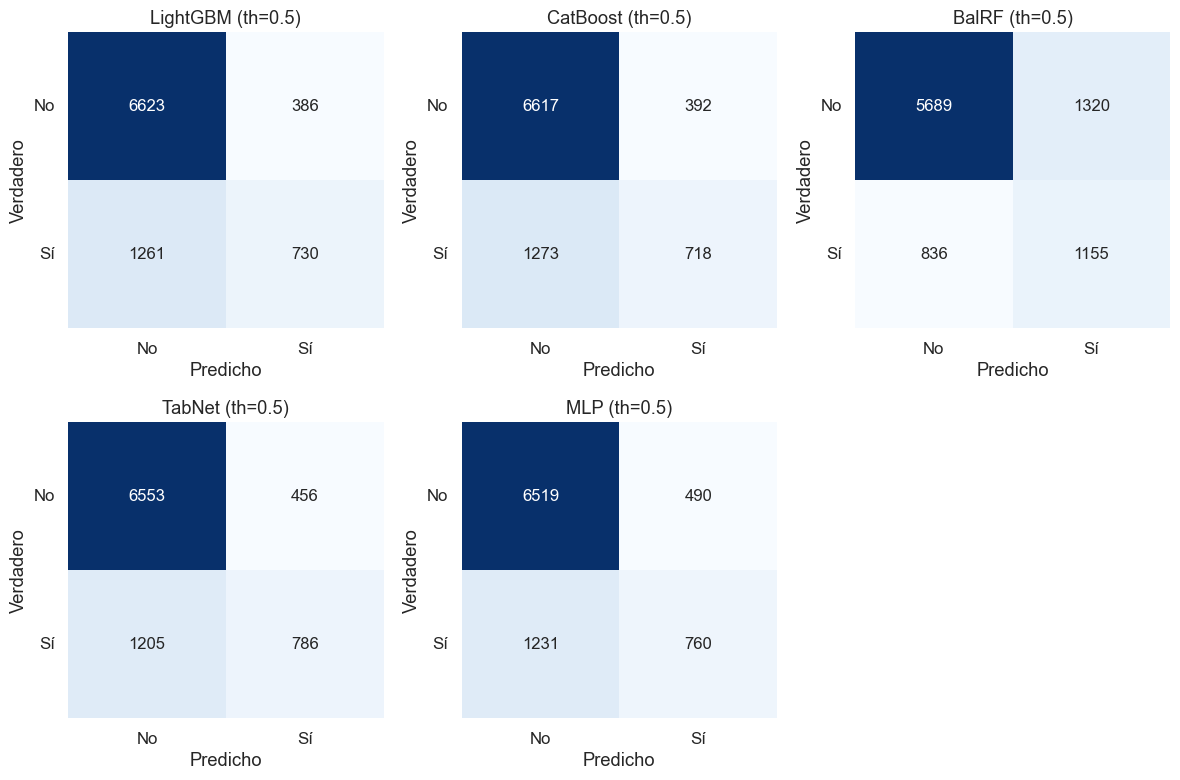

In [516]:
# Visualizar matrices de confusión

sns.set_theme(style="whitegrid", font_scale=1.1)
n_models = len(conf_matrices)
cols = 3
rows = int(np.ceil(n_models / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
axes = axes.flatten()

for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                cbar=False, ax=ax, annot_kws={'size':12})
    ax.set_title(f"{name} (th=0.5)")
    ax.set_xlabel('Predicho')
    ax.set_ylabel('Verdadero')
    ax.set_xticklabels(['No','Sí'])
    ax.set_yticklabels(['No','Sí'], rotation=0)

for ax in axes[len(conf_matrices):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [538]:
# Definiendo el pipeline de preprocesamiento y el modelo con sus hiperparámetros

# Definiendo model_configs con todos los modelos

model_configs = {

    #"TabNet": {
        #"model": TabNetClassifier(
            #n_d=16, n_a=16, n_steps=3,
            #gamma=1.0, momentum=0.3, lambda_sparse=1e-5,
            #optimizer_fn=torch.optim.Adam,
            #mask_type='entmax',
            #device_name='auto'
        #)
    #},
        "CatBoost": {
        "model": CatBoostClassifier(random_state=42, verbose=0)
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42)
    },
    "MLP": {
        "model": MLPClassifier(random_state=42, max_iter=200)
    },
    "BalRF": {
        "model": BalancedRandomForestClassifier(random_state=42)
    }
}


# Espacio de búsqueda acotado para RandomizedSearchCV

param_distributions = {
    #"TabNet": {
        #"clf__n_d":           randint(16,     33),
        #"clf__n_a":           randint(16,     33),
        #"clf__n_steps":       randint(3,      6),
        #"clf__gamma":         uniform(1.0,    1.0),
        #"clf__momentum":      uniform(0.3,    0.4),
        #"clf__lambda_sparse": uniform(1e-5,   1e-3),
    #},
        "CatBoost": {
        "clf__learning_rate":      uniform(0.01,   0.09),
        "clf__depth":              randint(6,       11),
        "clf__iterations":         randint(200,    501),
        "clf__l2_leaf_reg":        uniform(3,      7),
        "clf__random_strength":    uniform(0,     10),
        "clf__bagging_temperature":uniform(0,      1),
        "clf__border_count":       randint(32,     129),
        "clf__rsm":                uniform(0.6,    0.3),
        "clf__class_weights":      [[0,1], [1,4]],
        "clf__one_hot_max_size":   [0, 1],
    },
    "LightGBM": {
        "clf__learning_rate":      uniform(0.01,   0.09),
        "clf__n_estimators":       randint(100,    501),
        "clf__num_leaves":         randint(31,     129),
        "clf__max_depth":          randint(6,      13),
        "clf__subsample":          uniform(0.6,    0.3),
        "clf__colsample_bytree":   uniform(0.6,    0.3),
        "clf__reg_alpha":          uniform(0,      0.5),
        "clf__reg_lambda":         uniform(0,      0.5),
        "clf__scale_pos_weight":   [4],
    },
    "MLP": {
        "clf__hidden_layer_sizes": [(100,), (100, 50)],
        "clf__activation":         ["relu", "tanh"],
        "clf__alpha":              uniform(1e-5, 1e-3),
        "clf__learning_rate_init": uniform(1e-3, 1e-2),
        "clf__batch_size":         [64, 128],
        "clf__learning_rate":      ["adaptive"],
        "clf__early_stopping":     [True],
        "clf__tol":                uniform(1e-4, 1e-3),
    },
    "BalRF": {
        "clf__n_estimators":      randint(100,  301),
        "clf__max_depth":         [None, 10, 20, 30],
        "clf__max_features":      ["sqrt", "log2"],
        "clf__sampling_strategy": uniform(0.4, 0.4),
        "clf__min_samples_split": randint(2, 11),
        "clf__min_samples_leaf":  randint(1, 11),
        "clf__bootstrap":         [True],
    }
}

In [ ]:
# Aplicar RandomizedSearchCV para cada modelo

# Inicializar la lista para almacenar resultados
resultados_modelos = []

# Configurar caché para acelerar el pipeline
memory = Memory(location="./cachedir", verbose=0)

# Definir scorers
recall_scorer    = make_scorer(recall_score)
precision_scorer = make_scorer(precision_score)
f1_scorer        = make_scorer(f1_score)

# Iterar sobre cada modelo configurado
for model_name, config in model_configs.items():
    print(f"\n🔍 Ajustando hiperparámetros para: {model_name}")

    # Construir pipeline dinámico
    steps = [("preprocessor", preprocessor)]
    if model_name != "BalRF":
        steps.append(("smote", SMOTE(random_state=42)))
    steps.append(("clf", config["model"]))
    pipeline = ImbPipeline(steps, memory=memory)

    # RandomizedSearchCV optimizando Recall
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions[model_name],
        n_iter=50,
        cv=5,
        scoring={"Recall": recall_scorer,
                 "Precision": precision_scorer,
                 "F1": f1_scorer},
        refit="Recall",
        n_jobs=-1,
        verbose=2,
        random_state=42
    )
    random_search.fit(X_train, y_train)
    print("✔️ Mejor combinación de hiperparámetros:", random_search.best_params_)

    # Obtener probabilidades o scores
    best_model = random_search.best_estimator_
    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(X_test)[:, 1]
    elif hasattr(best_model, "decision_function"):
        y_prob = best_model.decision_function(X_test)
    else:
        y_prob = None

    # Calibración
    if y_prob is not None:
        preproc = best_model.named_steps["preprocessor"]
        smoter  = best_model.named_steps.get("smote", None)
        clf     = best_model.named_steps["clf"]

        X_tr, y_tr = preproc.transform(X_train), y_train
        if smoter:
            X_tr, y_tr = smoter.fit_resample(X_tr, y_tr)

        calibrator = CalibratedClassifierCV(estimator=clf, cv=3, method="sigmoid")
        calibrator.fit(X_tr, y_tr)

        y_prob = calibrator.predict_proba(preproc.transform(X_test))[:, 1]

    # Umbral óptimo para maximizar Recall con Precision >= 0.50
    if y_prob is not None:
        p_vals, r_vals, thresholds = precision_recall_curve(y_test, y_prob)
        p_vals, r_vals, thresholds = p_vals[:-1], r_vals[:-1], thresholds
        valid_idx = np.where(p_vals >= 0.50)[0]
        if valid_idx.size:
            idx = valid_idx[np.argmax(r_vals[valid_idx])]
        else:
            idx = np.argmax(r_vals)
        optimal_threshold = thresholds[idx]
    else:
        optimal_threshold = None

    # Predicción final
    if y_prob is not None:
        y_pred = (y_prob >= optimal_threshold).astype(int)
    else:
        y_pred = best_model.predict(X_test)

    # Métricas y reporte
    precision_metric = precision_score(y_test, y_pred)
    recall_metric    = recall_score(y_test, y_pred)
    f1_metric        = f1_score(y_test, y_pred)
    roc_auc          = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    resultados_modelos.append({
        "Modelo":         model_name,
        "Precision":      precision_metric,
        "Recall":         recall_metric,
        "F1":             f1_metric,
        "ROC_AUC":        roc_auc,
        "Umbral_optimo":  optimal_threshold
    })

    print(f"\n✅ Métricas para {model_name}")
    print(f"  Precision: {precision_metric:.3f}")
    print(f"  Recall:    {recall_metric:.3f}")
    print(f"  F1-score:  {f1_metric:.3f}")
    if roc_auc is not None:
        print(f"  ROC AUC:   {roc_auc:.3f}")
    if optimal_threshold is not None:
        print(f"  Umbral:    {optimal_threshold:.2f}")

    print("\n📋 Classification Report:\n", classification_report(y_test, y_pred, digits=3))
    print("🧩 Matriz de Confusión:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusión - {model_name}")
    plt.show()
    print("--------------------------------------------------")

# Resumen final ordenado por Recall
df_resumen = (pd.DataFrame(resultados_modelos)
                .set_index("Modelo")
                .sort_values("Recall", ascending=False))
print("\n🔎 Resultados Finales:")
print(df_resumen)



🔍 Ajustando hiperparámetros para: CatBoost
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
# Espacios para BayesSearchCV

bayes_spaces = {
    # Para CatBoost
    'CatBoost': {
        'clf__learning_rate':      Real(0.015, 0.035, prior='log-uniform'),
        'clf__depth':              Integer(6, 10),
        'clf__iterations':         Integer(200, 400),
        'clf__l2_leaf_reg':        Real(5.0, 9.0, prior='uniform'),
        'clf__random_strength':    Real(0.5, 1.5, prior='uniform'),
        'clf__bagging_temperature':Real(0.2, 0.5, prior='uniform'),
        'clf__border_count':       Integer(100, 128),
        'clf__rsm':                Real(0.6, 0.85, prior='uniform'),
        # listas mutables → tuplas inmutables
        'clf__class_weights':      Categorical([(0, 1)]),
        'clf__one_hot_max_size':   Categorical([0]),
    },

    # Para LightGBM
    'LightGBM': {
        'clf__learning_rate':      Real(0.02, 0.04, prior='log-uniform'),
        'clf__n_estimators':       Integer(100, 200),
        'clf__num_leaves':         Integer(50, 80),
        'clf__max_depth':          Integer(4, 8),
        'clf__subsample':          Real(0.6, 0.8, prior='uniform'),
        'clf__colsample_bytree':   Real(0.7, 0.85, prior='uniform'),
        'clf__reg_alpha':          Real(0.1, 0.4, prior='uniform'),
        'clf__reg_lambda':         Real(0.05, 0.2, prior='uniform'),
        'clf__scale_pos_weight':   Categorical([4]),
    },

    # Para MLPClassifier
    'MLP': {
        'clf__alpha':              Real(2e-4, 8e-4, prior='log-uniform'),
        'clf__learning_rate_init': Real(5e-3, 1.5e-2, prior='log-uniform'),
        'clf__tol':                Real(2e-4, 8e-4, prior='log-uniform'),
        'clf__hidden_layer_sizes': Categorical([(100,)]),
        'clf__activation':         Categorical(['tanh']),
        'clf__batch_size':         Categorical([64]),
        'clf__learning_rate':      Categorical(['adaptive']),
        'clf__early_stopping':     Categorical([True]),
    },

    # Para BalancedRandomForestClassifier
    'BalRF': {
        'clf__n_estimators':       Integer(150, 250),
        'clf__max_depth':          Integer(10, 30),
        'clf__max_features':       Categorical(['sqrt']),
        'clf__sampling_strategy':  Real(0.6, 0.9, prior='uniform'),
        'clf__min_samples_split':  Integer(2, 8),
        'clf__min_samples_leaf':   Integer(1, 4),
        'clf__bootstrap':          Categorical([True]),
    }
}

In [ ]:
# Aplicar BayesSearchCV para cada modelo

resultados_modelos = []
memory = Memory(location="./cachedir", verbose=0)

recall_scorer    = make_scorer(recall_score)
precision_scorer = make_scorer(precision_score)
f1_scorer        = make_scorer(f1_score)

for model_name, cfg in model_configs.items():
    print(f"\n🔍 Ajustando hiperparámetros para: {model_name}")
    steps = [("preprocessor", preprocessor)]
    if model_name != "BalRF":
        steps.append(("smote", SMOTE(random_state=42)))
    steps.append(("clf", cfg["model"]))
    pipeline = ImbPipeline(steps, memory=memory)

    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=bayes_spaces[model_name],
        n_iter=50,
        cv=5,
        scoring={"Recall": recall_scorer,
                 "Precision": precision_scorer,
                 "F1": f1_scorer},
        refit="Recall",
        n_jobs=-1,
        verbose=2,
        random_state=42
    )
    bayes_search.fit(X_train, y_train)
    print("✔️ Mejor combinación de hiperparámetros:", bayes_search.best_params_)

    best = bayes_search.best_estimator_
    if hasattr(best, "predict_proba"):
        y_prob = best.predict_proba(X_test)[:, 1]
    elif hasattr(best, "decision_function"):
        y_prob = best.decision_function(X_test)
    else:
        y_prob = None

    if y_prob is not None:
        pre, sm, clf = best.named_steps["preprocessor"], best.named_steps.get("smote"), best.named_steps["clf"]
        X_tr, y_tr = pre.transform(X_train), y_train
        if sm:
            X_tr, y_tr = sm.fit_resample(X_tr, y_tr)
        calib = CalibratedClassifierCV(clf, cv=3, method="sigmoid")
        calib.fit(X_tr, y_tr)
        y_prob = calib.predict_proba(pre.transform(X_test))[:, 1]

    if y_prob is not None:
        p, r, t = precision_recall_curve(y_test, y_prob)
        p, r, t = p[:-1], r[:-1], t
        idxs = np.where(p >= 0.50)[0]
        idx = idxs[np.argmax(r[idxs])] if idxs.size else np.argmax(r)
        thr = t[idx]
    else:
        thr = None

    y_pred = (y_prob >= thr).astype(int) if y_prob is not None else best.predict(X_test)

    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    resultados_modelos.append({
        "Modelo": model_name,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC_AUC": auc,
        "Umbral_optimo": thr
    })

    print(f"\n✅ Métricas para {model_name}")
    print(f"  Precision: {prec:.3f}")
    print(f"  Recall:    {rec:.3f}")
    print(f"  F1-score:  {f1:.3f}")
    if auc is not None: print(f"  ROC AUC:   {auc:.3f}")
    if thr is not None: print(f"  Umbral:    {thr:.2f}")

    print("\n📋 Classification Report:\n", classification_report(y_test, y_pred, digits=3))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusión - {model_name}")
    plt.show()
    print("—" * 50)

import pandas as pd
df_resumen = pd.DataFrame(resultados_modelos).set_index("Modelo").sort_values("Recall", ascending=False)
print("\n🔎 Resultados Finales:\n", df_resumen)